In [1]:
#Importing Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
from scipy.optimize import curve_fit
from scipy.special import gamma
from sklearn.metrics import r2_score
import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use("seaborn")

%matplotlib inline

In [2]:
def gauss(x, mu, sigma, scale):
    return scale * np.exp(-1 * ((x - mu) ** 2) / (2 * (sigma ** 2) )) 

def weib(x, k, a, b, g):
    return k * g * b * (a ** b) * np.exp(-1 * g * ((a / x)  ** b)) / (x ** (b + 1))

def lognormal(x, f, kp):
    return np.exp(-(np.log(x) - kp)**2 / (2*(f**2)))/(x*f*2.51)

def loglogistic(x, kb, kf):
    return (kf/kb * np.power(x/kb, kf-1))/np.power((1+np.power(x/kb, kf)), 2)

def iterativeCurveFit(func, x, y):
    outliersweight = None
    for i in range(10):
        popt, pcov = curve_fit(func, x, y, sigma=outliersweight, maxfev=100000)
        pred = np.array([func(px, *popt) for px in x])
        old = outliersweight
        outliersweight = np.abs(pred - y)
        outliersweight = 1 - np.tanh(outliersweight)
        outliersweight = outliersweight / np.max(outliersweight)
        outliersweight = softmax(1 - outliersweight)
        if i > 1 and sum(abs(old - outliersweight)) < 0.001:
            break
    
    return popt, pcov

def expectedEnd(name , curve, index, startDate):
    dic = {}
    dic['x'] = np.arange(1, 4*index)
    dic[name] = (curve*y_data_cases_max).astype('int')
    df = pd.DataFrame(dic, columns= list(dic.keys()))
    if df[-1:][name].values < 1:
        end_index = min(df[(df.index > index) & (df[name] < 1)].index)
    else:
        end_index = max(df[-1:].index)
    cases = df.iloc[end_index, 1]
    end_date = datetime.datetime.strptime(startdate, '%Y-%m-%d') + datetime.timedelta(days = end_index)
    return end_date.strftime('%Y-%m-%d'), cases

In [3]:
df = pd.read_csv('owid-covid-data.csv')
ind = df[df['location'] == 'India']
ind.reset_index(inplace = True)

ind.head()

,index,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,33559,IND,Asia,India,2020-01-30,1.0,1.0,NaN,NaN,NaN,...,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
1,33560,IND,Asia,India,2020-01-31,1.0,0.0,NaN,NaN,NaN,...,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
2,33561,IND,Asia,India,2020-02-01,1.0,0.0,NaN,NaN,NaN,...,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
3,33562,IND,Asia,India,2020-02-02,2.0,1.0,NaN,NaN,NaN,...,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
4,33563,IND,Asia,India,2020-02-03,3.0,1.0,NaN,NaN,NaN,...,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645


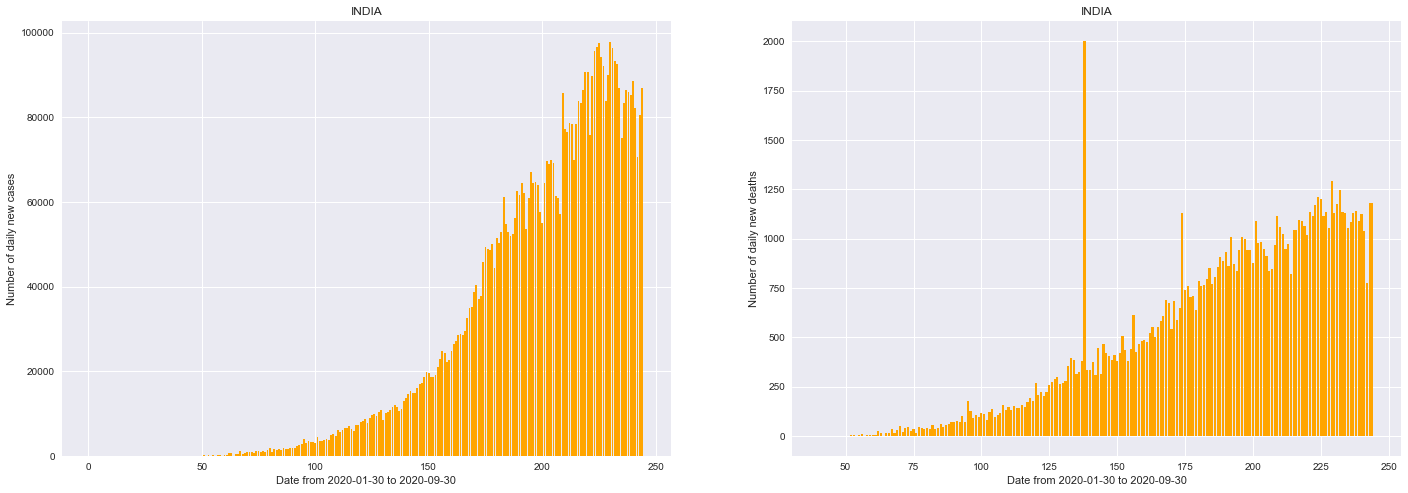

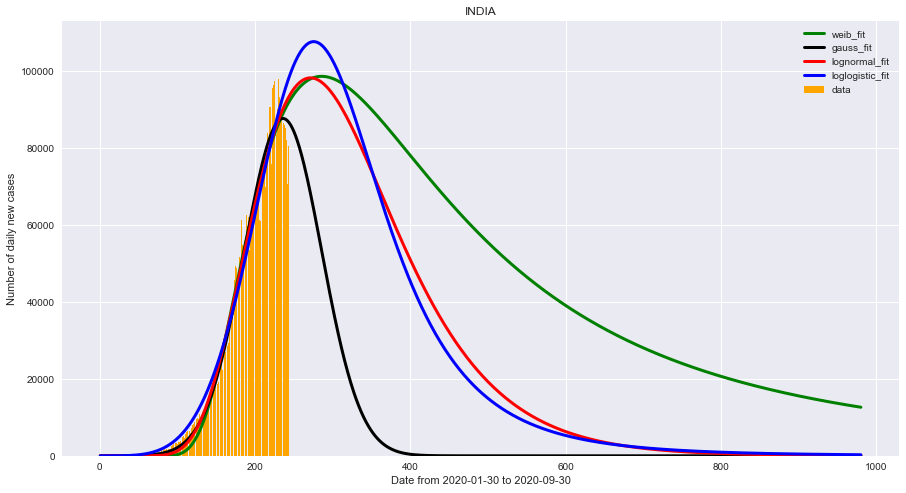

In [4]:
index = 245
startdate = min(ind.date)
enddate = max(ind.date[1:index])

x_data, y_data_cases, y_data_deaths = (ind.index.values[1:index], ind.new_cases.values[1:index], ind.new_deaths.values[1:index])
x_data_max, y_data_cases_max, y_data_deaths_max = (max(x_data), max(y_data_cases), max(y_data_deaths))

fig, axes = plt.subplots(1, 2, figsize=(24,8))
      
axes[0].bar(x_data, y_data_cases,color = 'orange')
axes[0].set_title("INDIA")
axes[0].set_xlabel('Date from {} to {}'.format(startdate, enddate))
axes[0].set_ylabel("Number of daily new cases")

axes[1].bar(x_data, y_data_deaths,color = 'orange')
axes[1].set_title("INDIA")
axes[1].set_xlabel('Date from {} to {}'.format(startdate, enddate))
axes[1].set_ylabel("Number of daily new deaths");
plt.savefig('India_data.png')

xdata = x_data/x_data_max
ydata_cases = y_data_cases/y_data_cases_max
ydata_deaths = y_data_deaths/y_data_deaths_max

popt_ind_weib, pcov_ind_weib = iterativeCurveFit(weib, xdata, ydata_cases)
popt_ind_gauss, pcov_ind_gauss = iterativeCurveFit(gauss, xdata, ydata_cases)
popt_ind_lognormal, pcov_ind_lognormal = iterativeCurveFit(lognormal, xdata, ydata_cases)
popt_ind_loglogistic, pcov_ind_loglogistic = iterativeCurveFit(loglogistic, xdata, ydata_cases)

# split data into train/test
msk = np.random.rand(index-1) < 0.8
train_x = xdata[msk]
test_x = xdata[~msk]
train_y = ydata_cases[msk]
test_y = ydata_cases[~msk]

y_hat = weib(test_x, *popt_ind_weib)
z_hat = gauss(test_x, *popt_ind_gauss)
t_hat = lognormal(test_x, *popt_ind_lognormal)
l_hat = loglogistic(test_x, *popt_ind_loglogistic)

xt = np.arange(1, 4*index)
xt = 4*xt/max(xt)

y = weib(xt, *popt_ind_weib)
z = gauss(xt, *popt_ind_gauss)
t = lognormal(xt, *popt_ind_lognormal)
l = loglogistic(xt, *popt_ind_loglogistic)

india = []
models = ['Weibull', 'Gauss', 'LogNormal', ' LogLogistic']
hats = [y_hat, z_hat, t_hat, l_hat]
names = ['y', 'z', 't', 'l']
curves = [y, z, t, l]

for i in range(4):
    india.append({
        'Function' : models[i],
        'Mean Absolute Error' : np.mean(np.absolute(hats[i] - test_y)),
        'Mean Squared Error' : np.mean((hats[i] - test_y) ** 2),
        'R2-Score' : r2_score(hats[i] , test_y),
        'Expected_Last_date': expectedEnd(names[i], curves[i], index, startdate)[0],
        'Expected_cases': expectedEnd(names[i], curves[i], index, startdate)[1]
    })


plt.figure(figsize = (15,8))
plt.bar(xdata*x_data_max, ydata_cases*y_data_cases_max, color = 'orange', label = 'data')
plt.plot(xt*index, y*y_data_cases_max, 'green', linewidth = 3.0, label = 'weib_fit')
plt.plot(xt*index, z*y_data_cases_max, 'black', linewidth = 3.0, label = 'gauss_fit')
plt.plot(xt*index, t*y_data_cases_max, 'red', linewidth = 3.0, label = 'lognormal_fit')
plt.plot(xt*index, l*y_data_cases_max, 'blue', linewidth = 3.0, label = 'loglogistic_fit')
plt.title('INDIA')
plt.legend(loc = 'best')
plt.ylabel("Number of daily new cases")
plt.xlabel('Date from {} to {}'.format(startdate, enddate))
plt.savefig('india.png')
plt.show()


In [5]:
df_2 = pd.DataFrame(india, columns= ['Function', 'Mean Absolute Error', 'Mean Squared Error', 'R2-Score', 'Expected_Last_date','Expected_cases'])
df_2.to_csv('FinalMatrics_India.csv')
df_2

,Function,Mean Absolute Error,Mean Squared Error,R2-Score,Expected_Last_date,Expected_cases
0,Weibull,0.035607,0.002729,0.977581,2022-10-04,12627
1,Gauss,0.029254,0.002134,0.982057,2021-05-17,0
2,LogNormal,0.035883,0.002793,0.977044,2022-10-04,73
3,LogLogistic,0.042170,0.003835,0.968414,2022-10-04,271


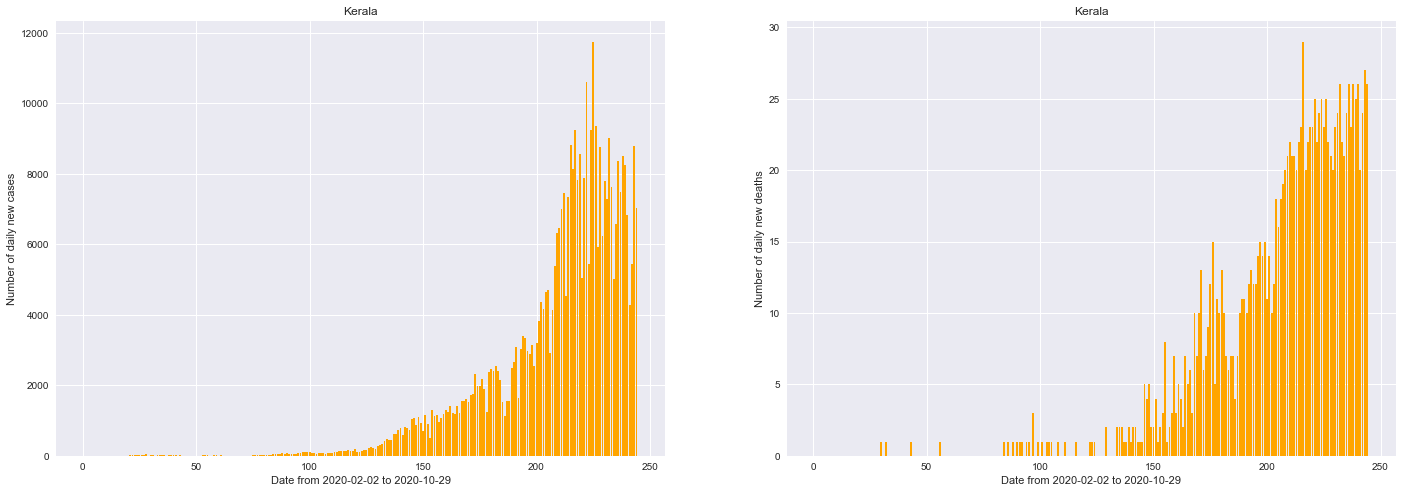

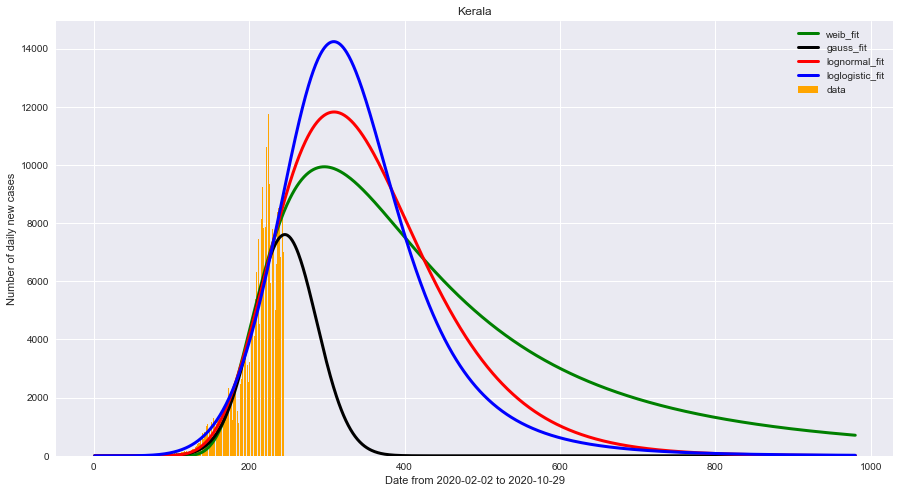

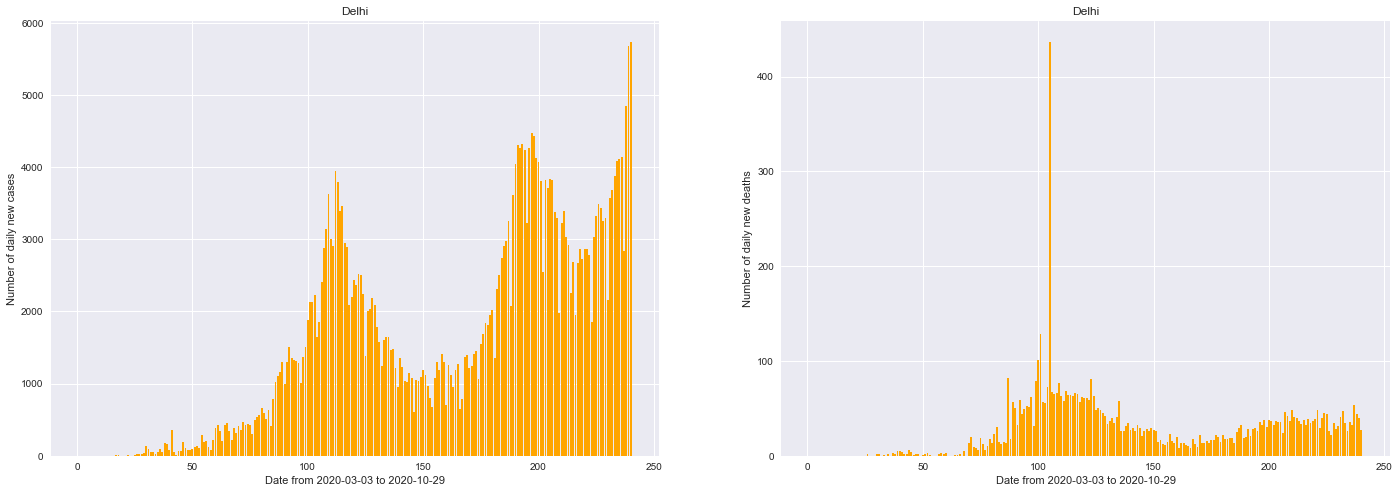

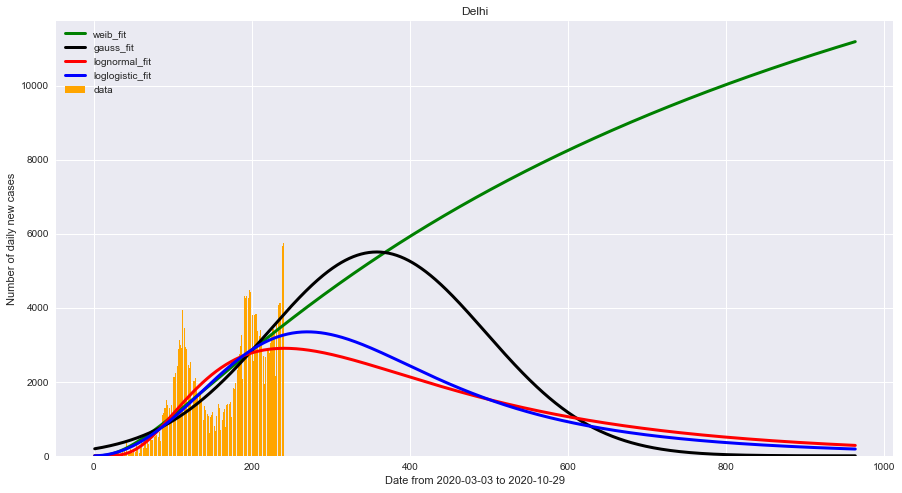

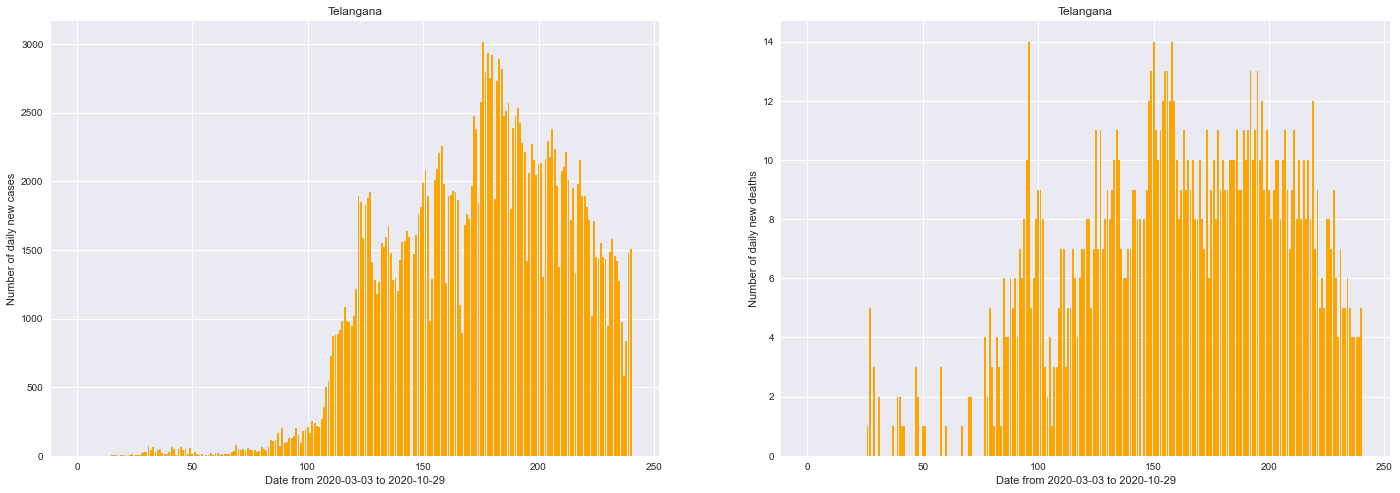

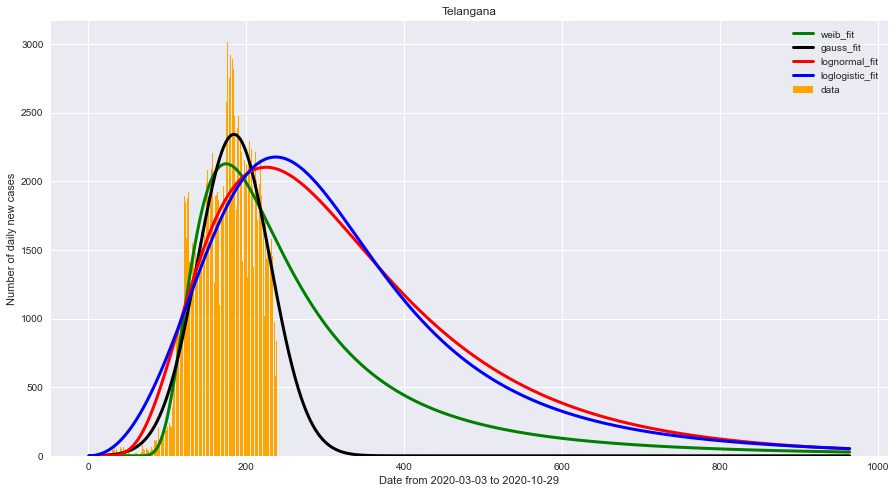

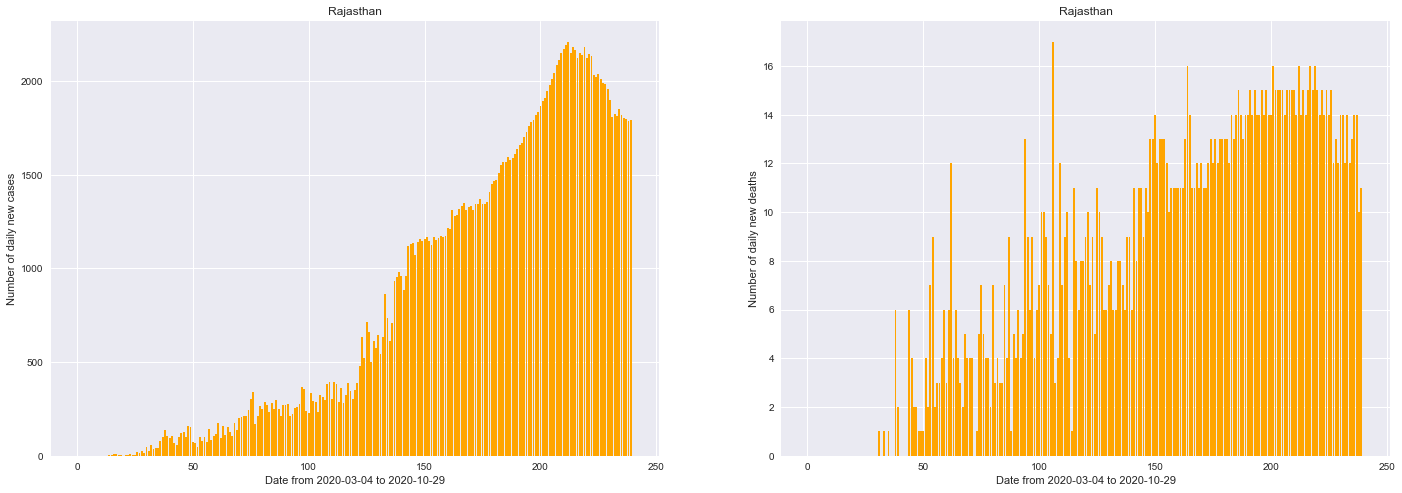

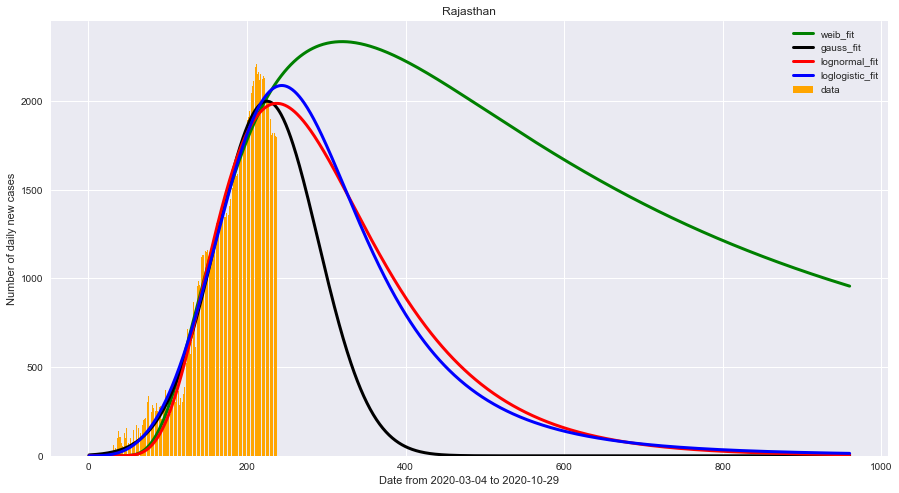

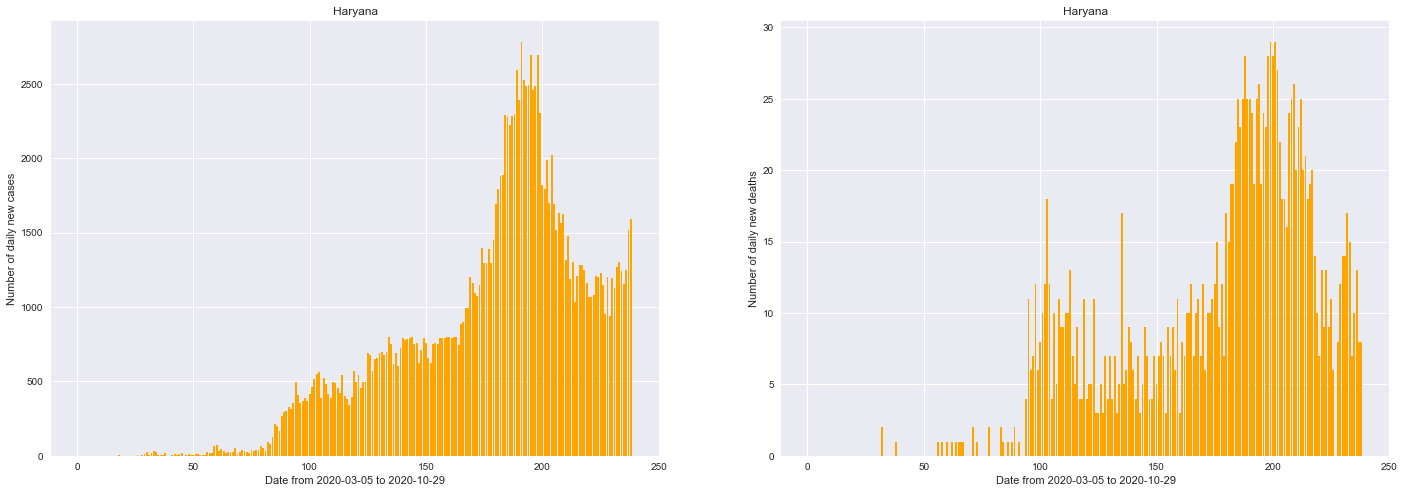

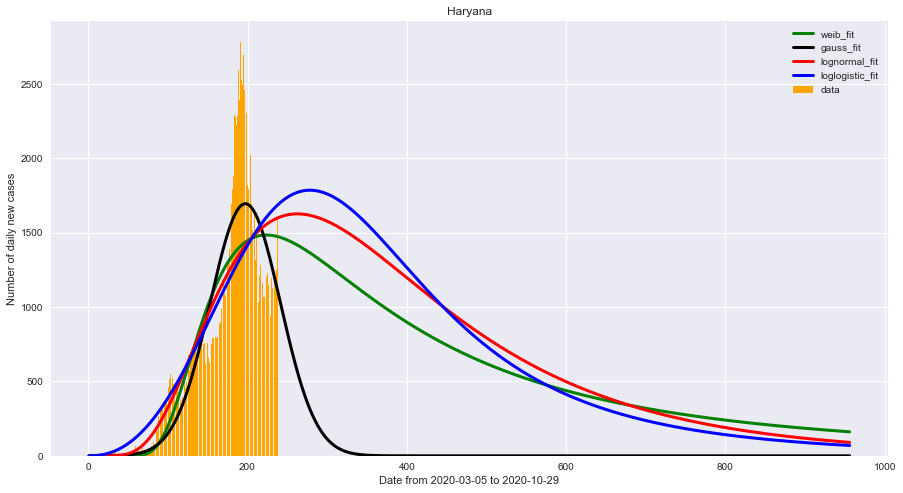

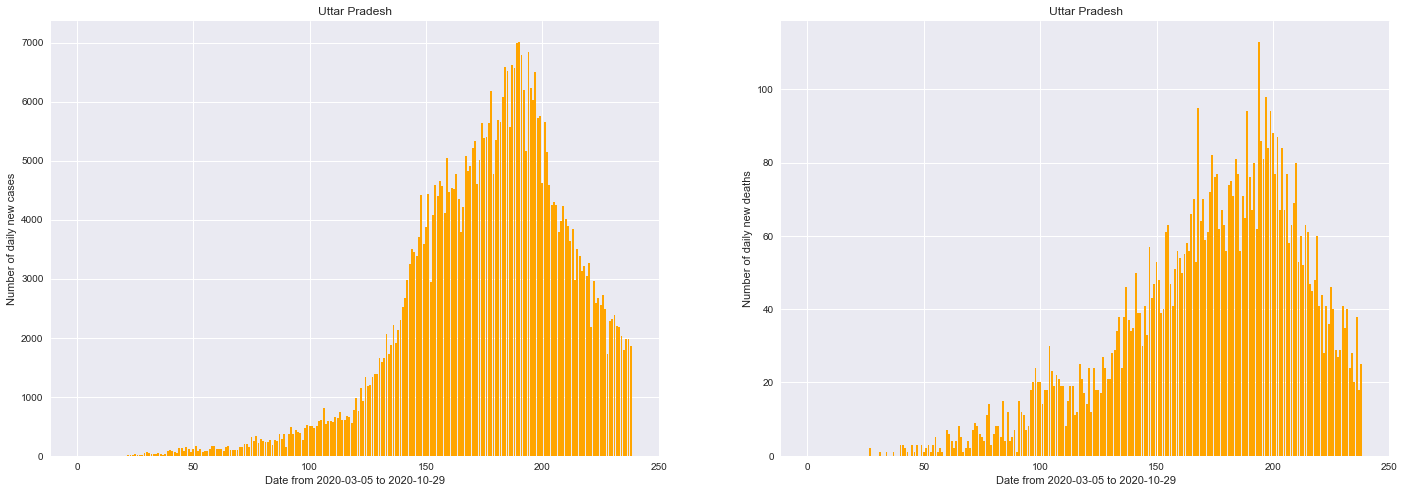

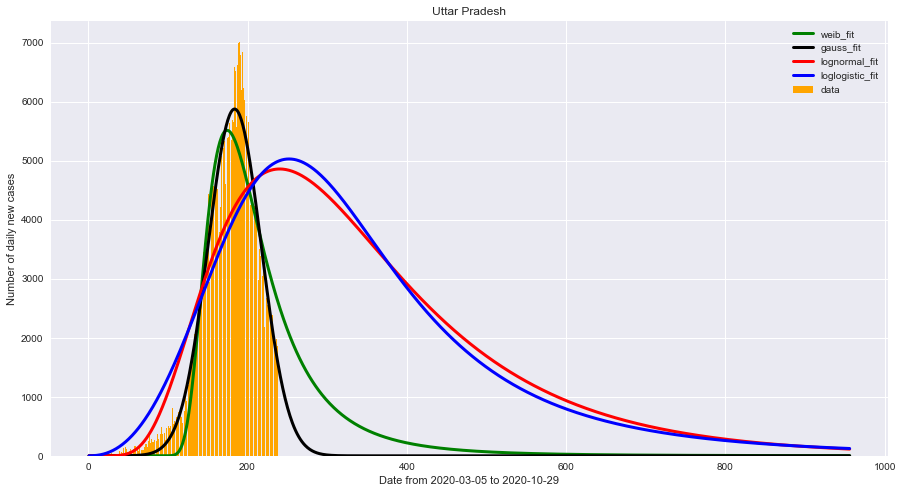

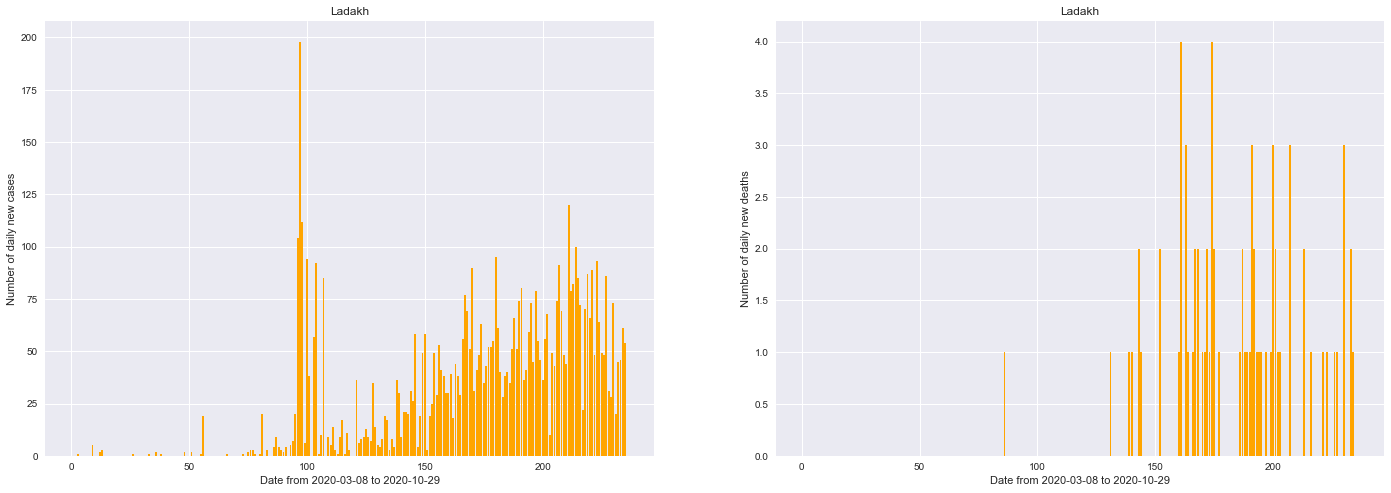

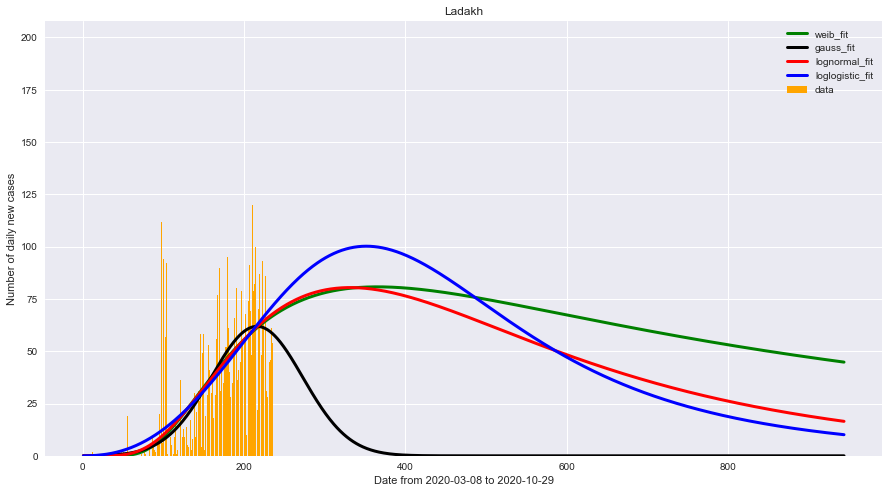

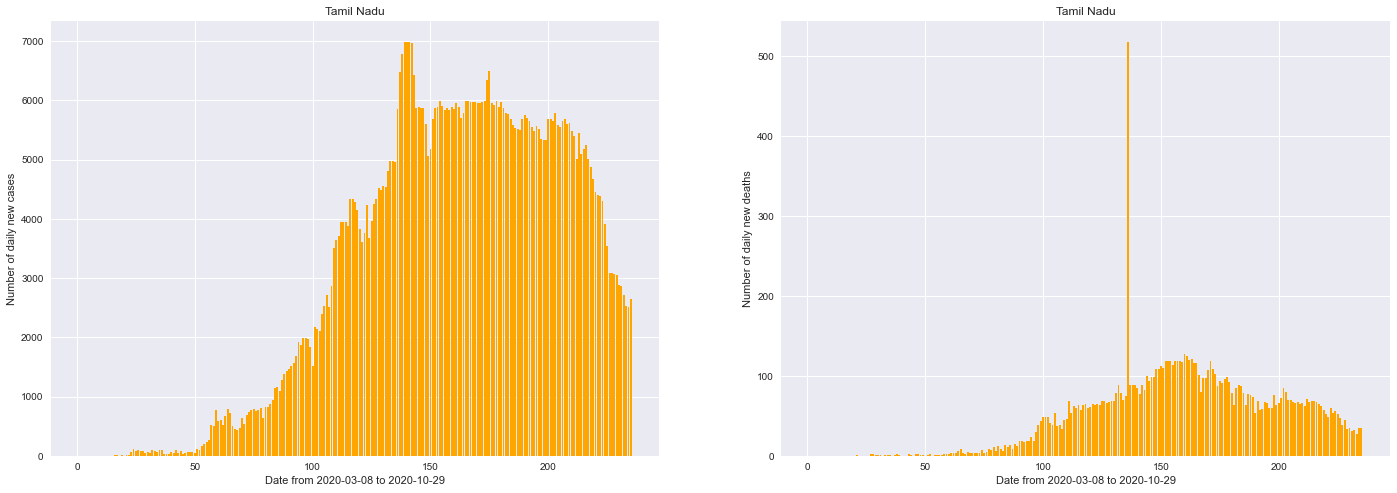

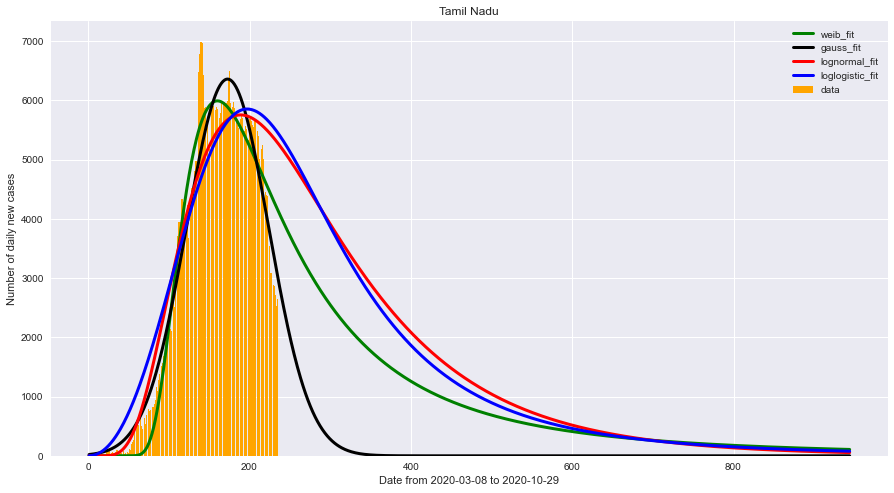

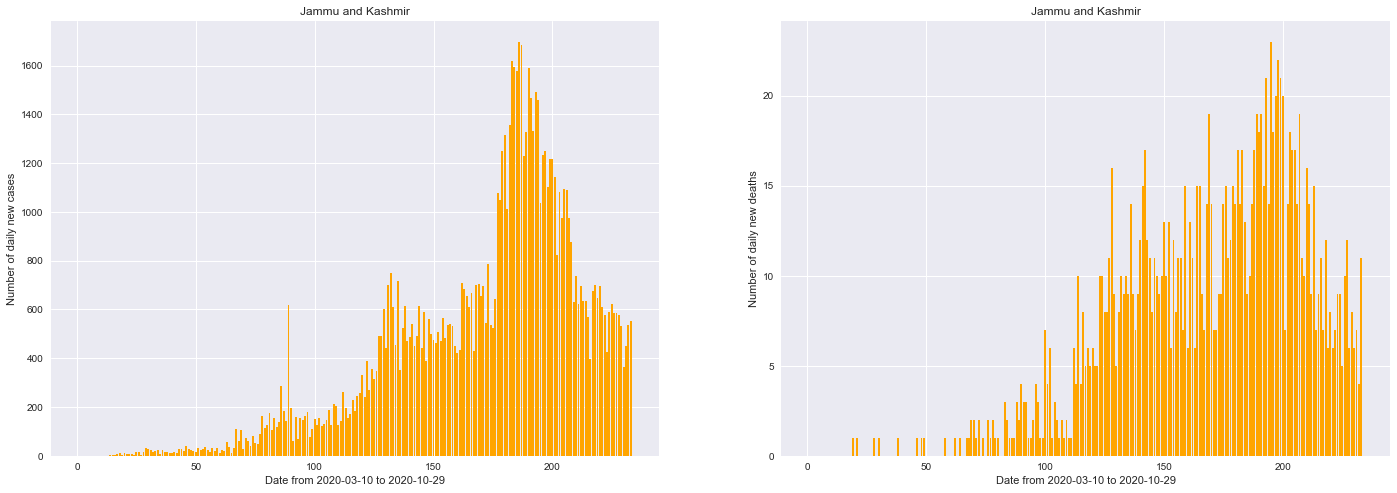

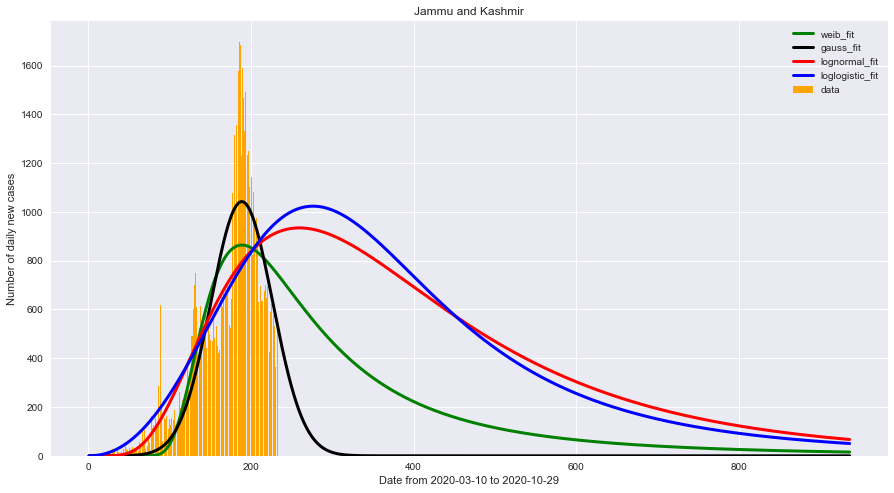

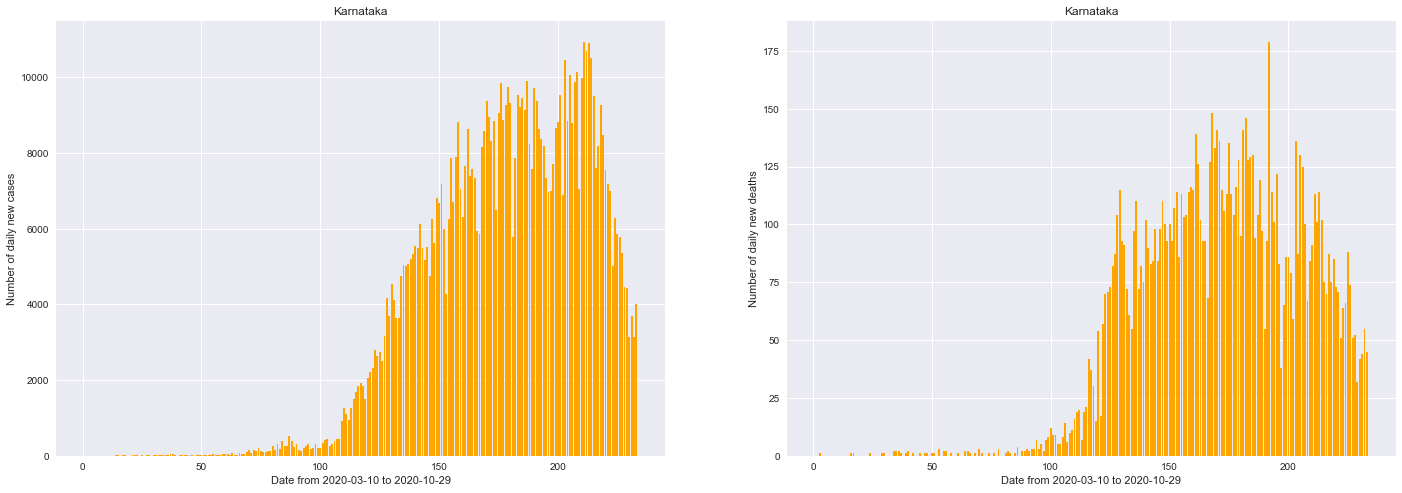

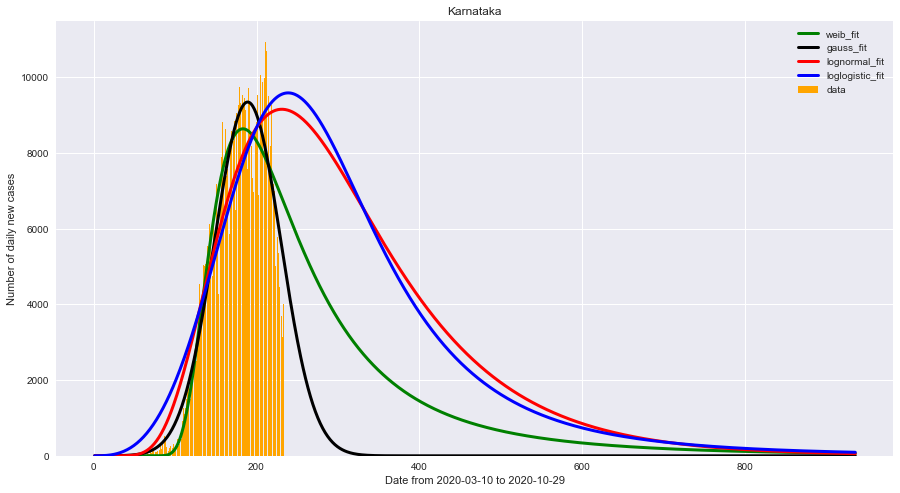

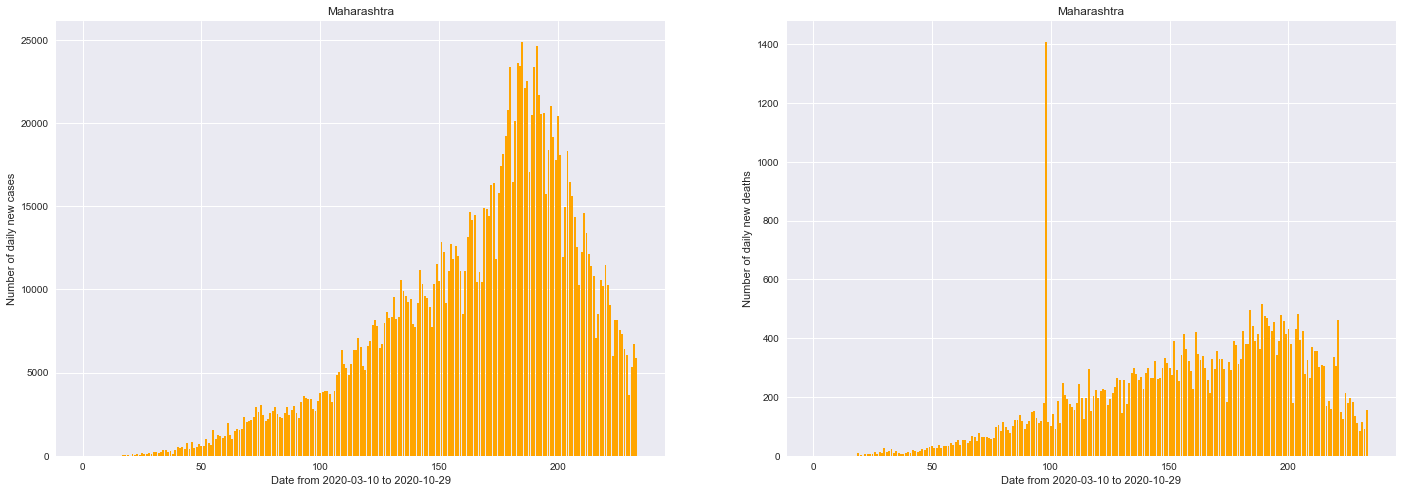

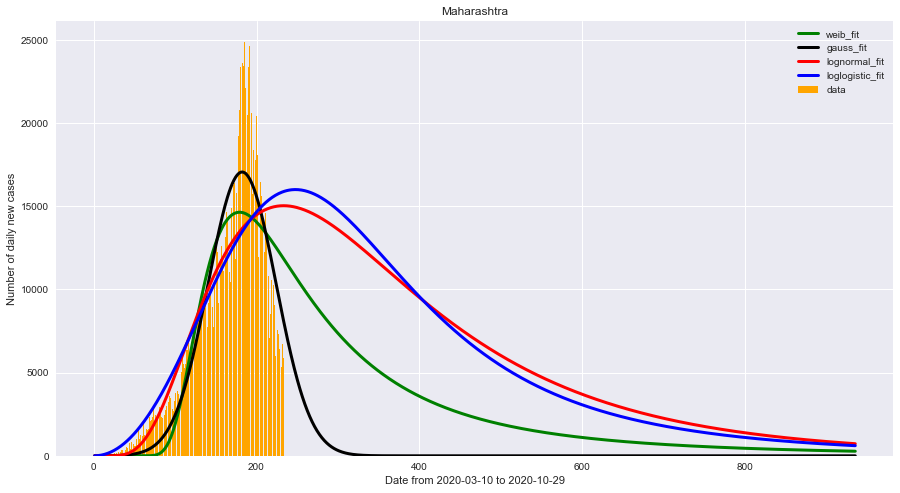

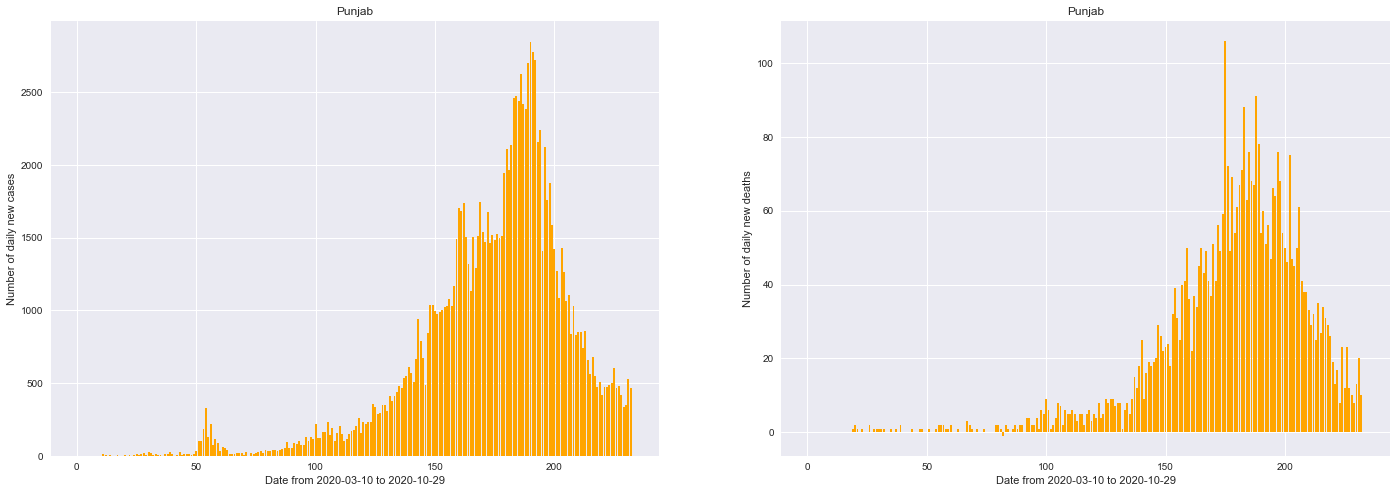

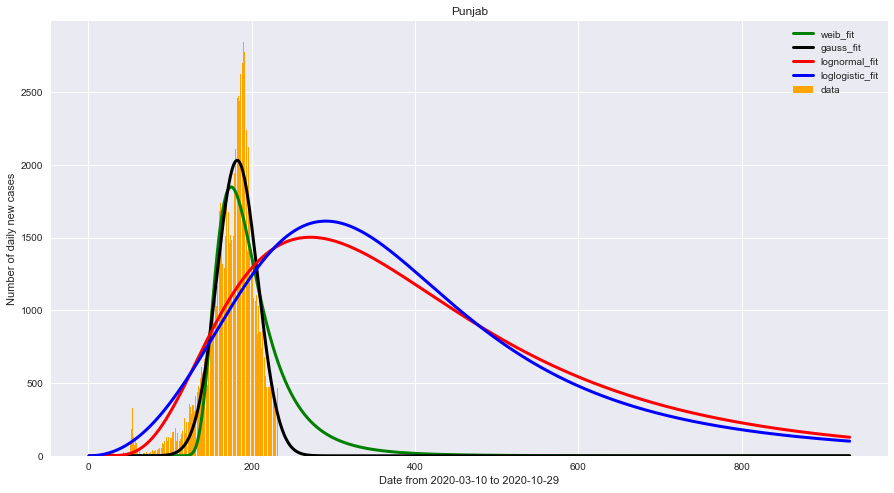

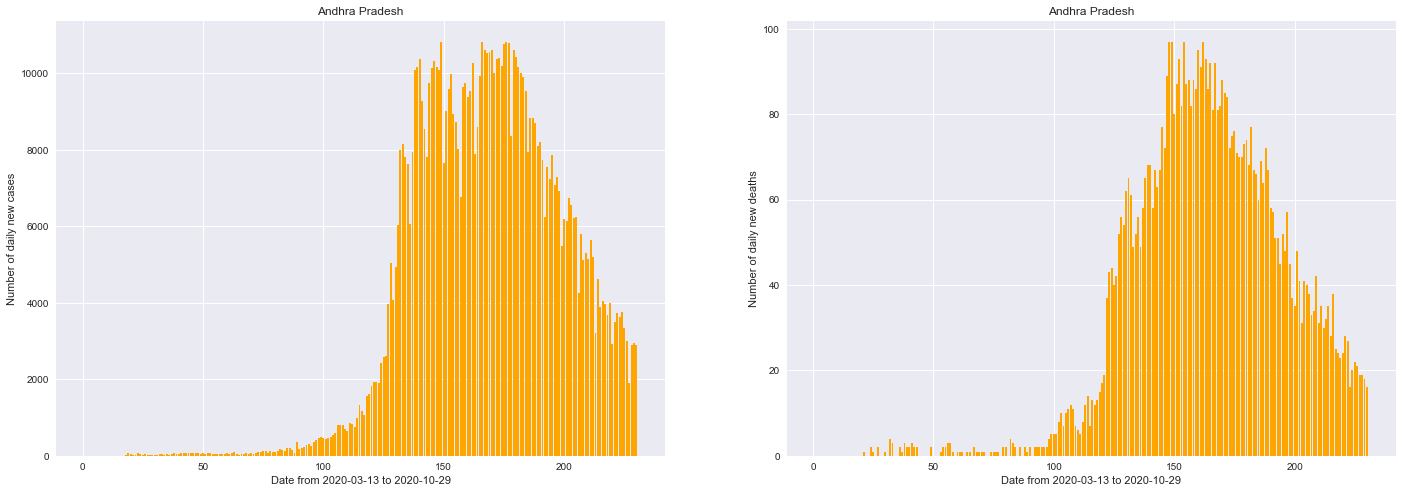

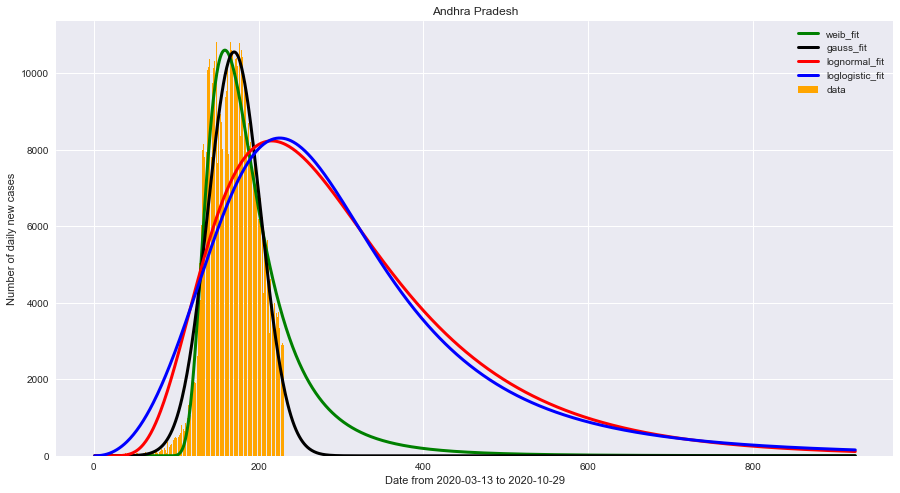

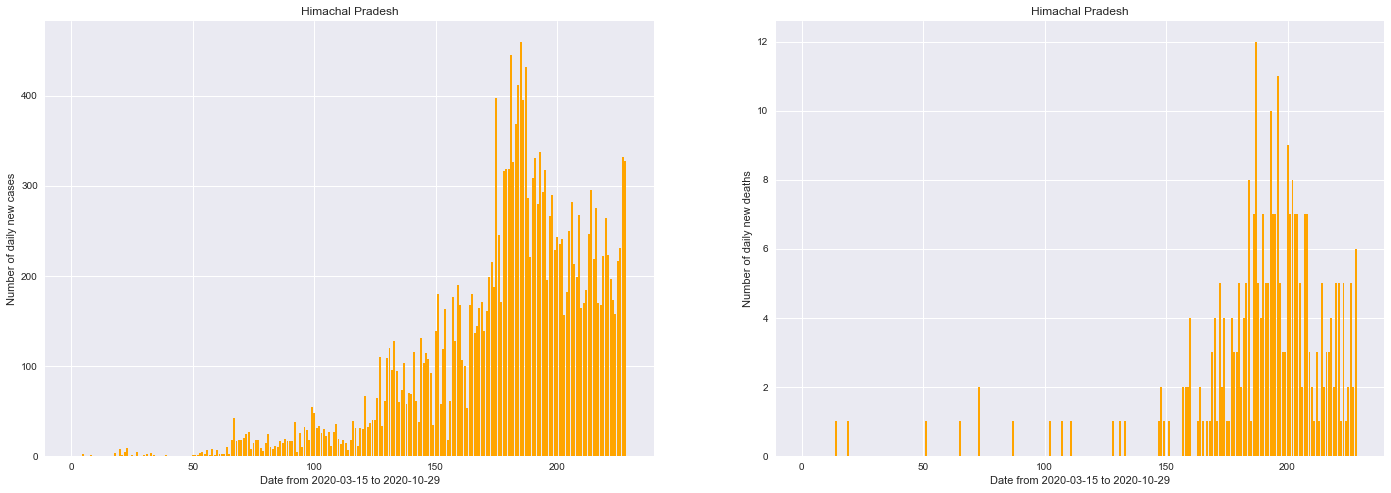

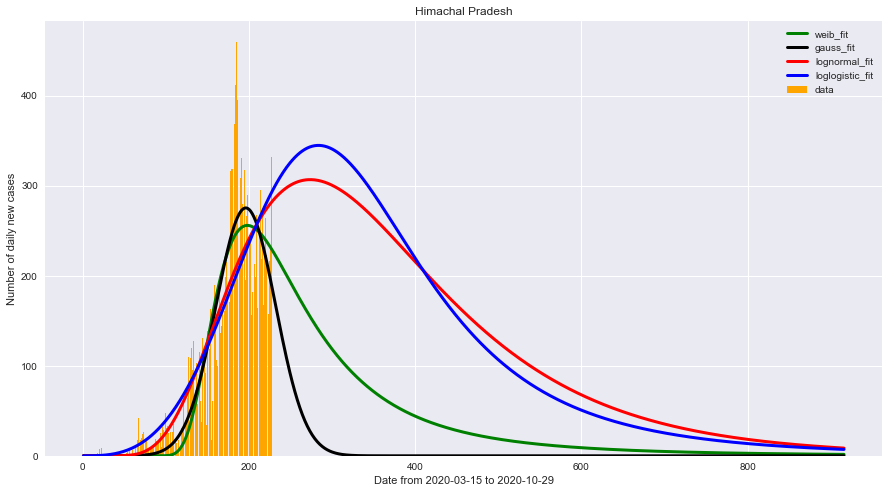

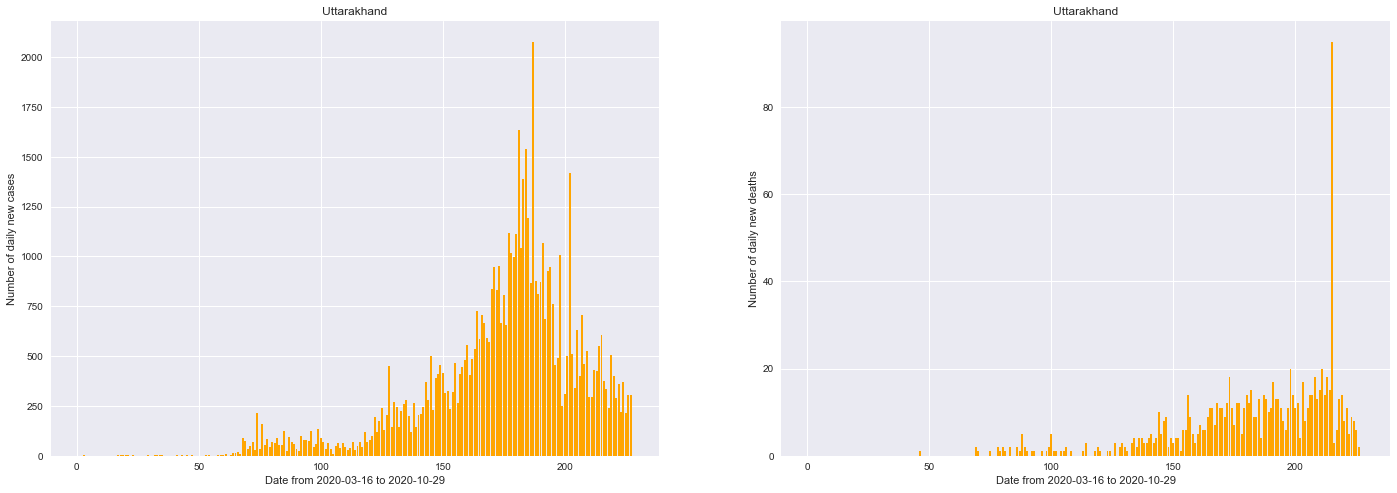

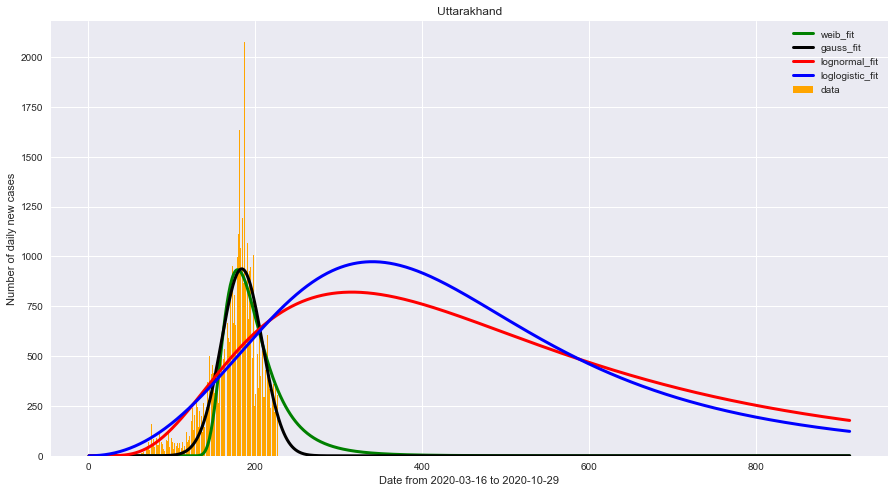

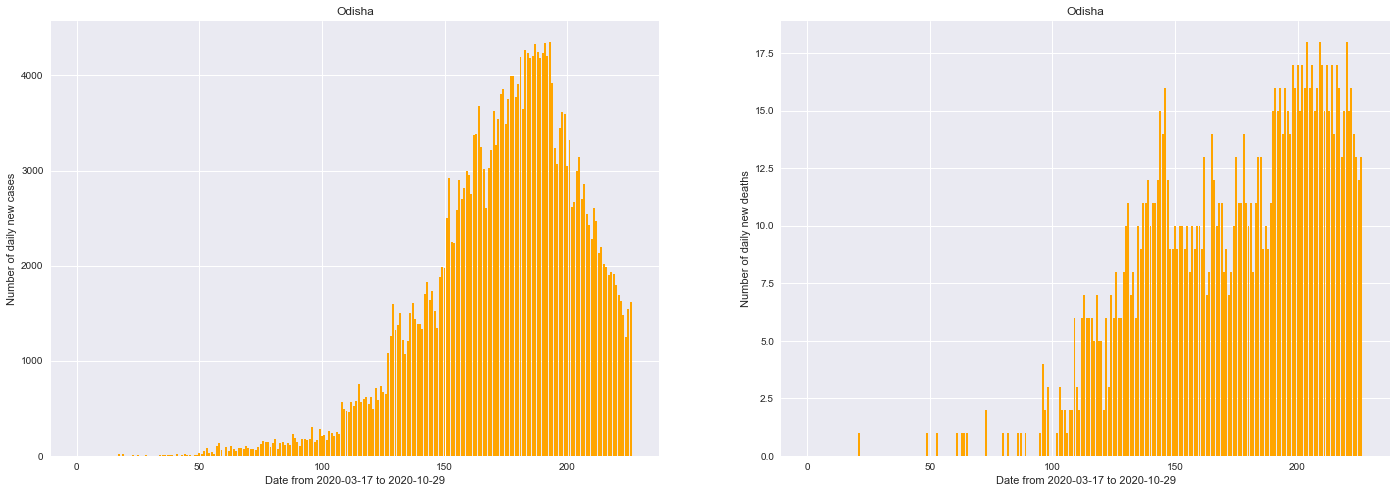

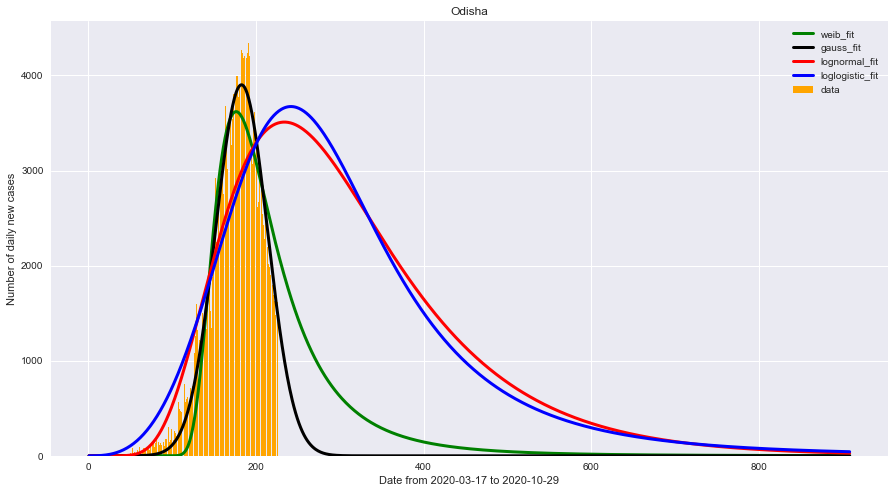

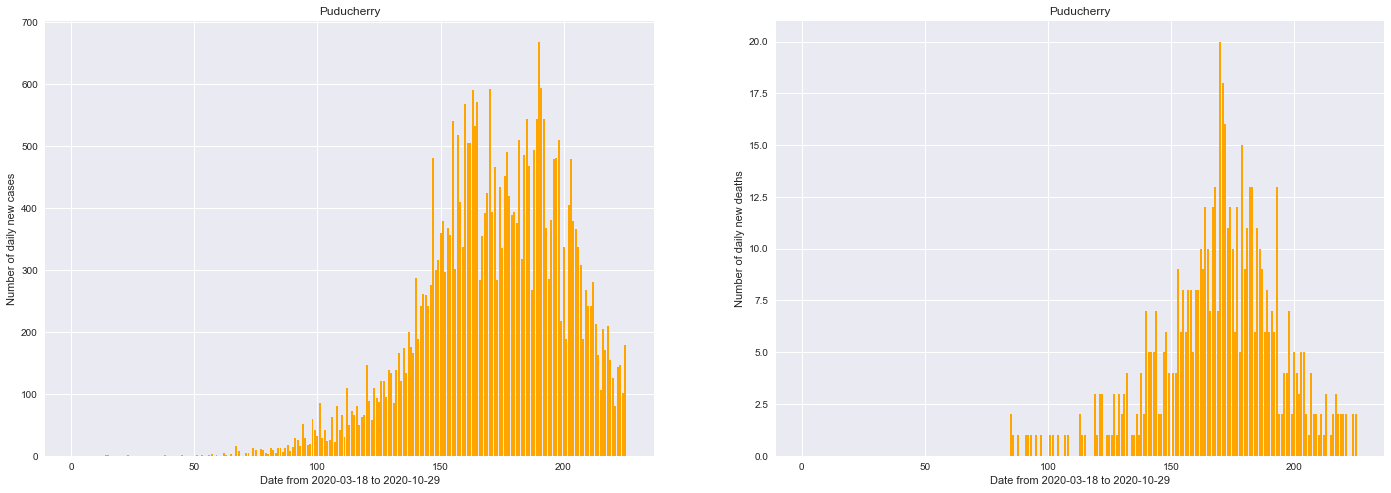

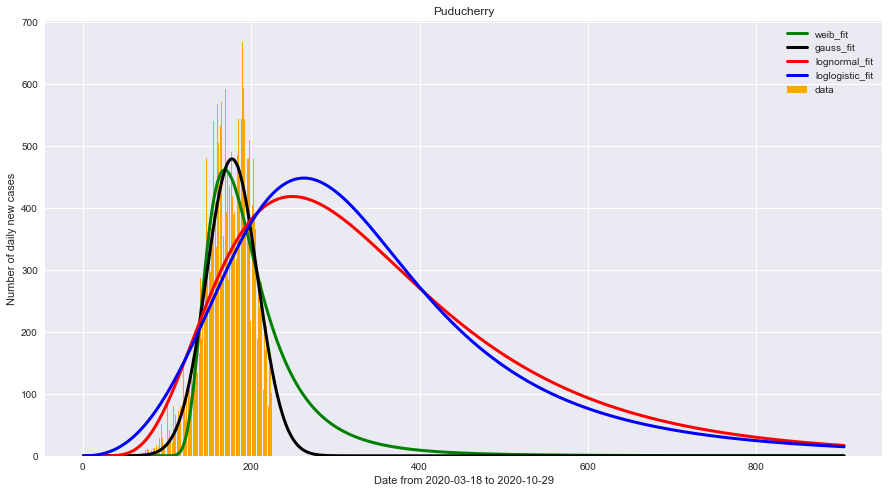

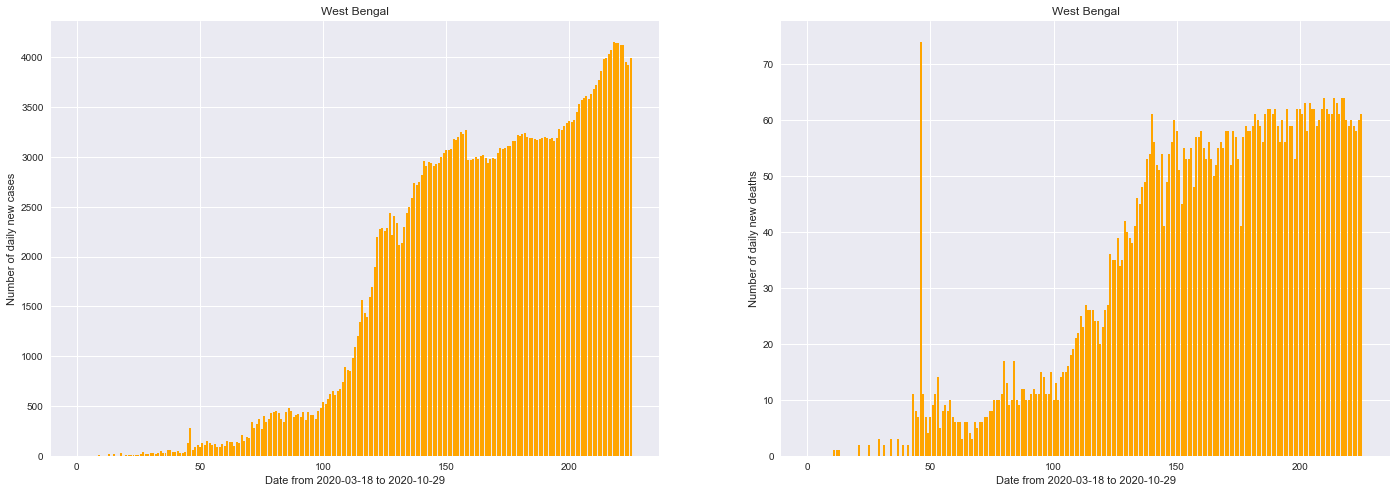

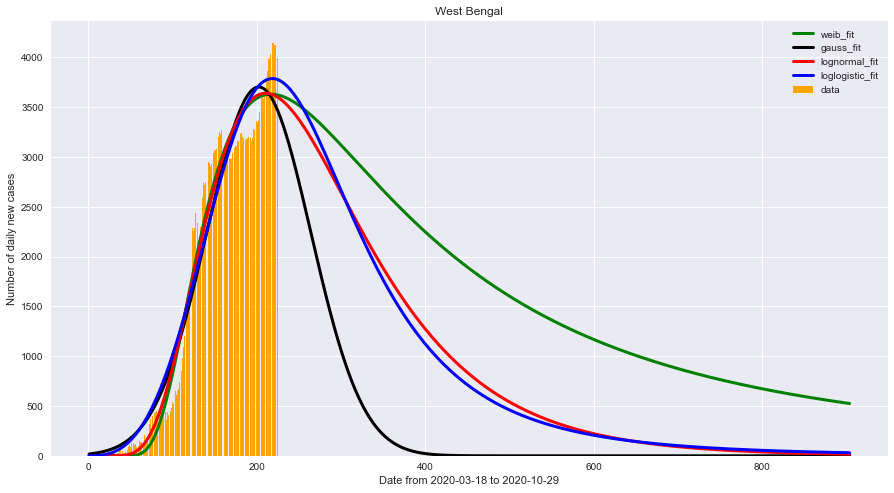

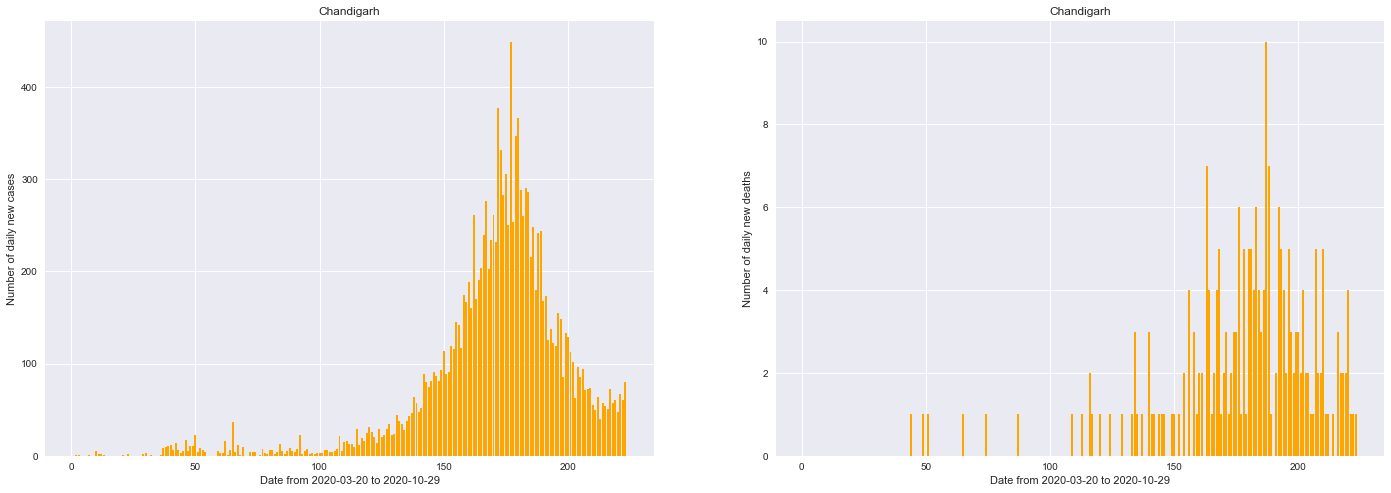

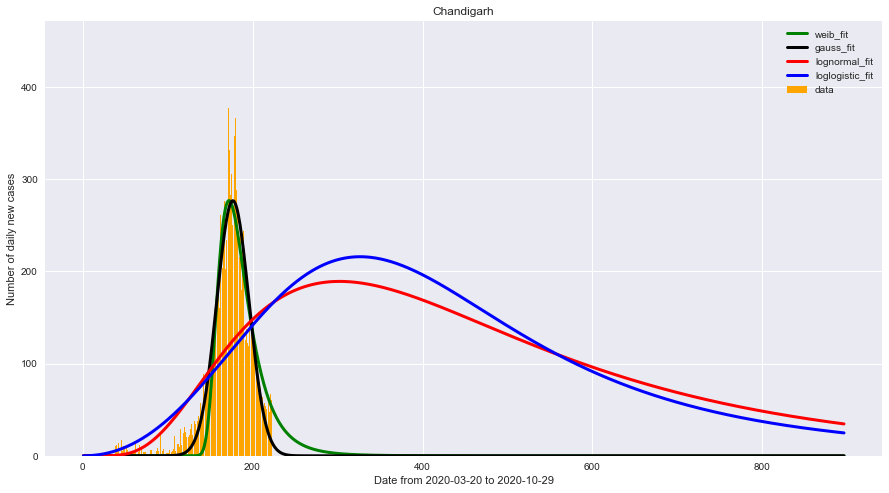

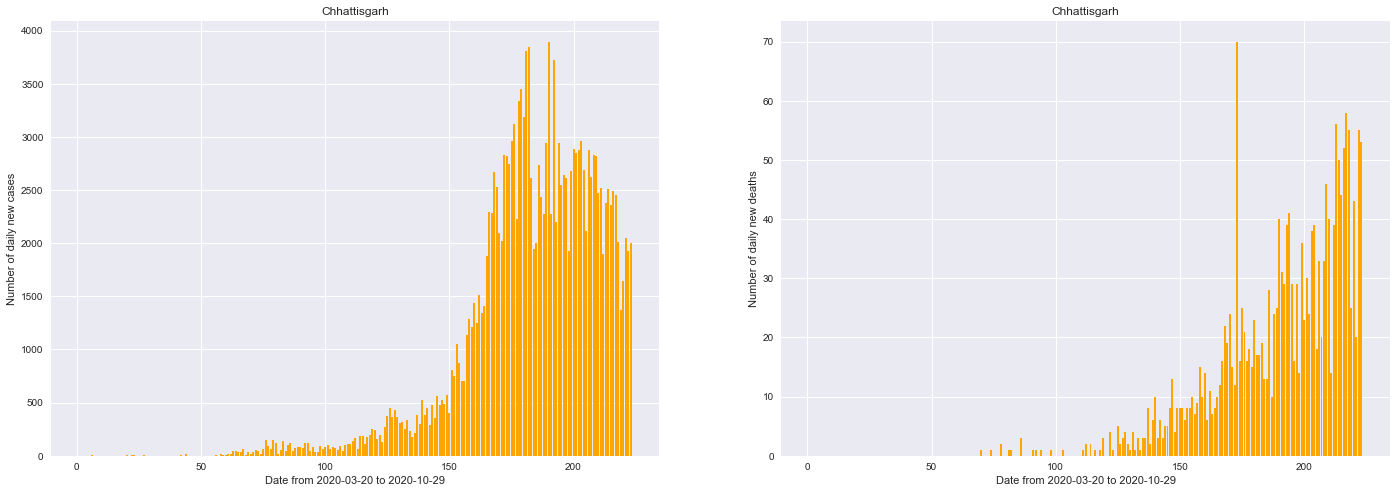

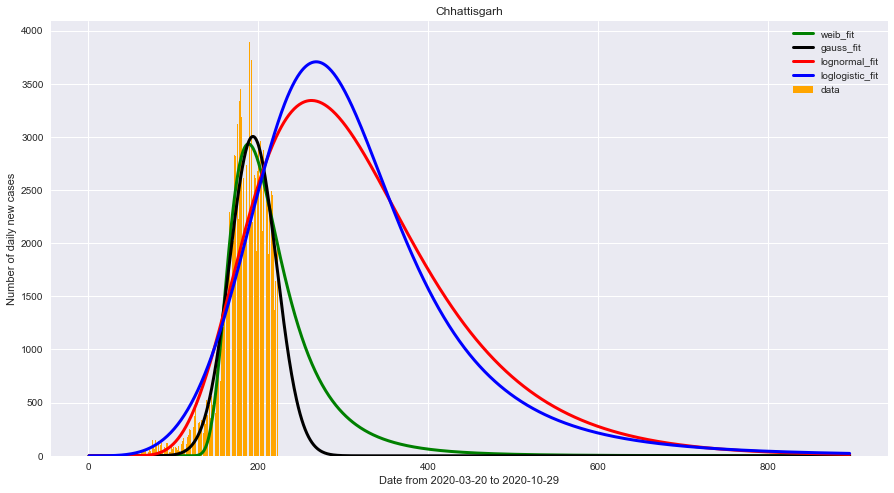

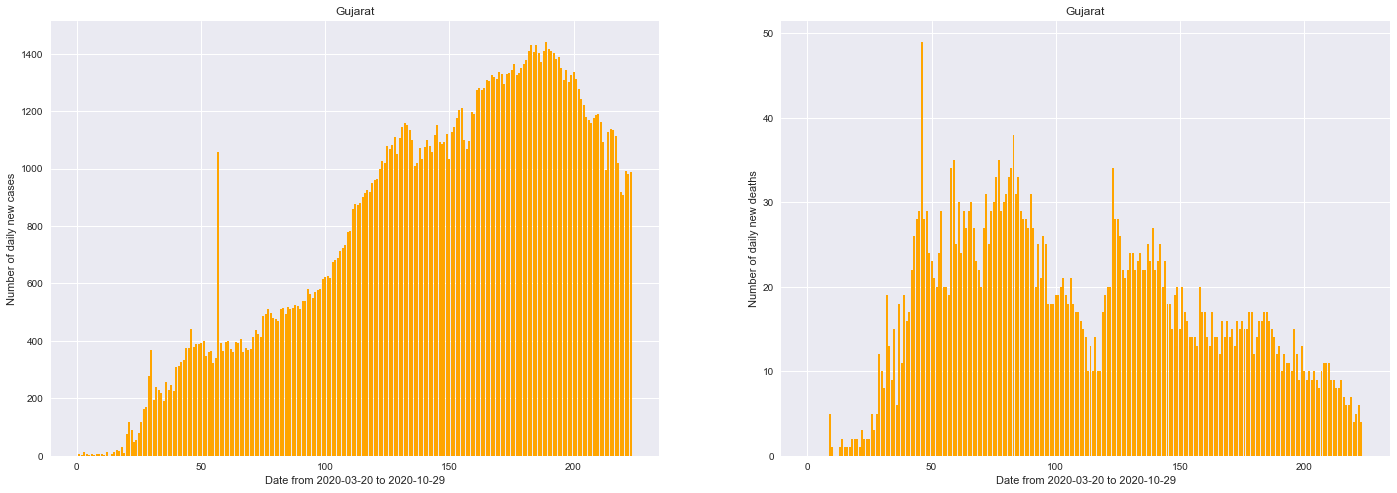

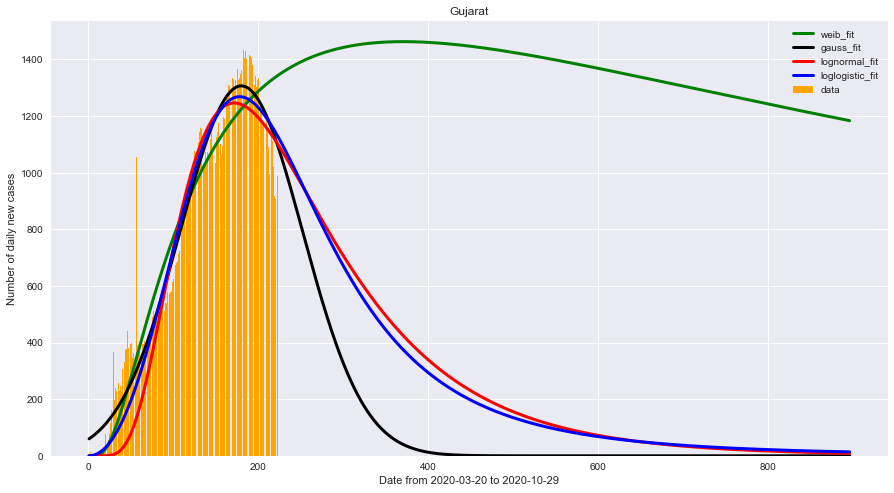

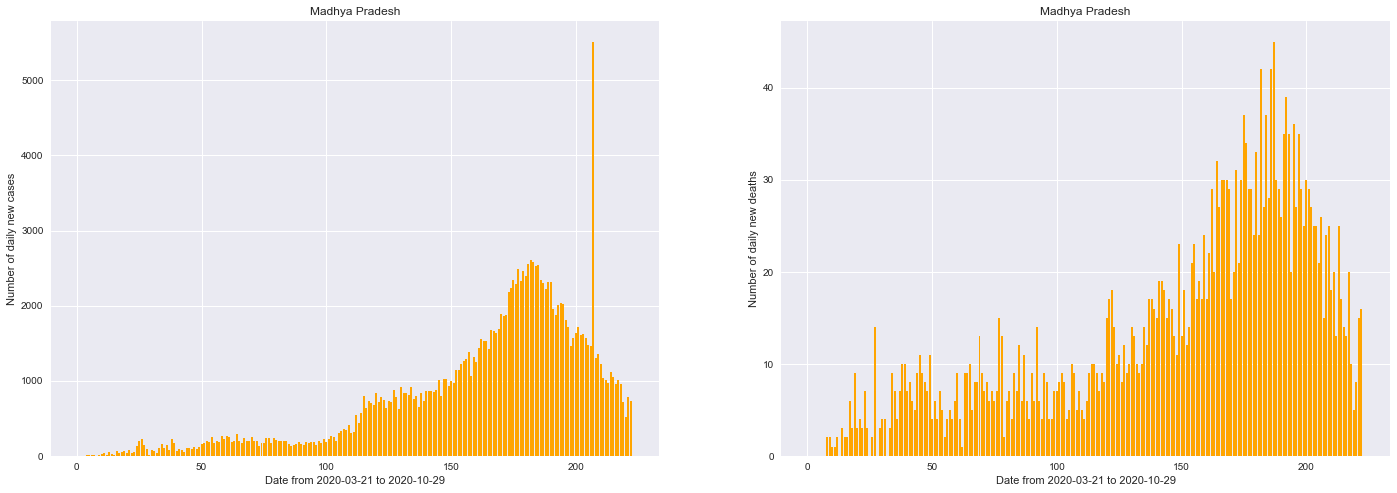

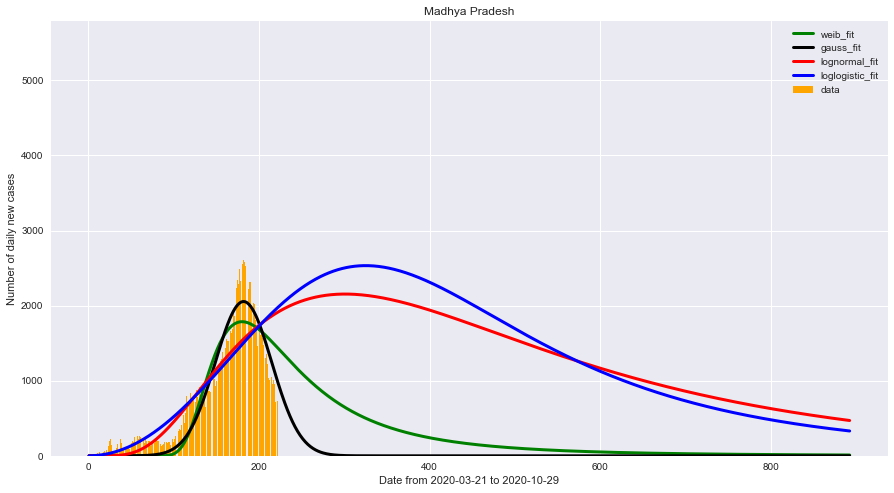

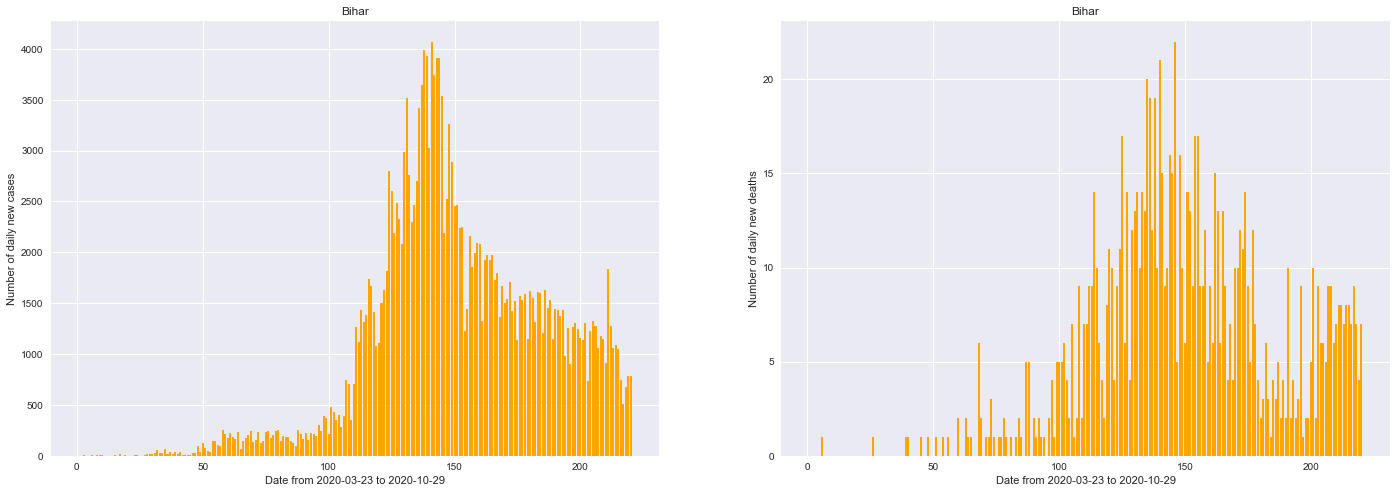

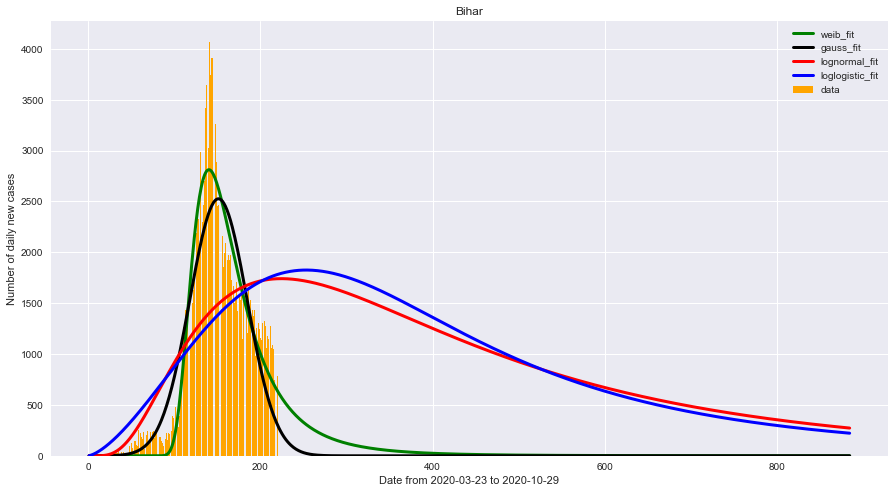

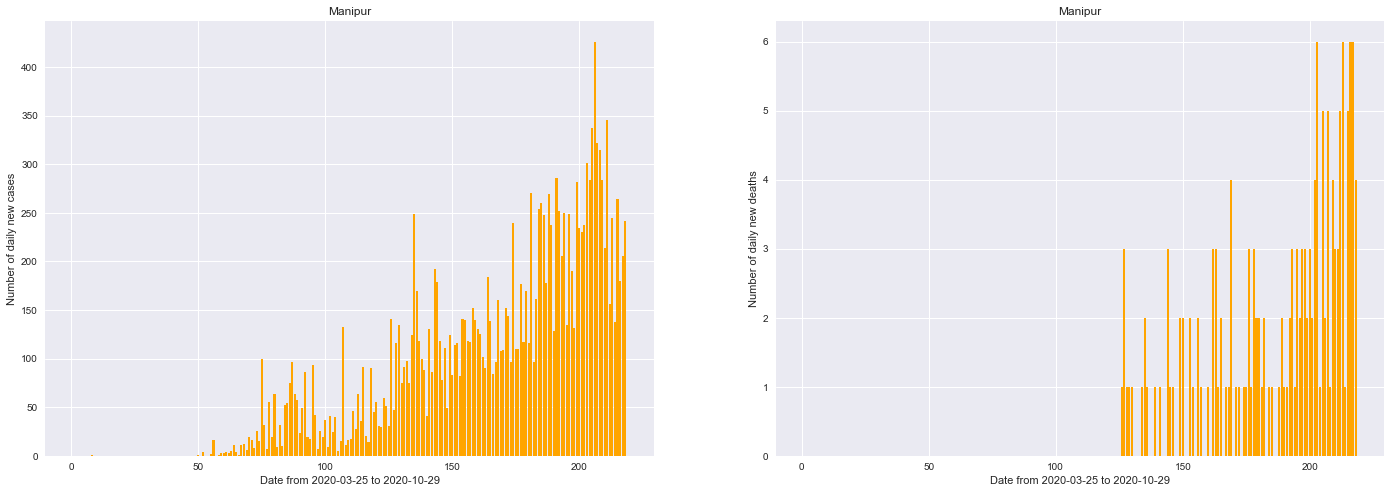

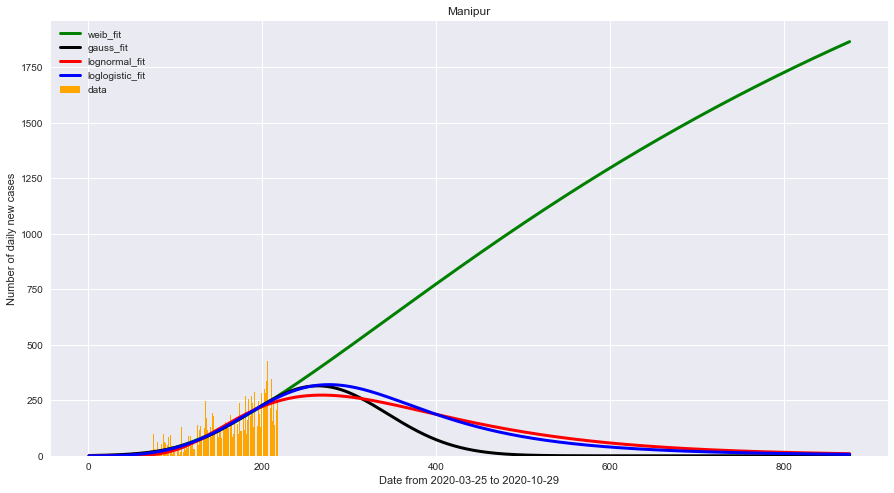

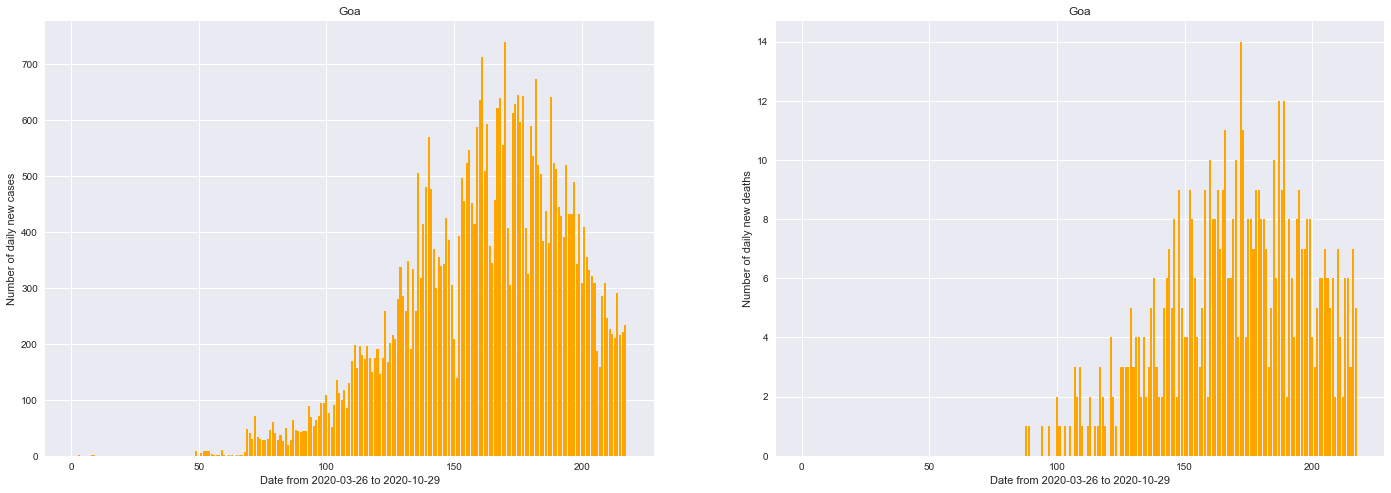

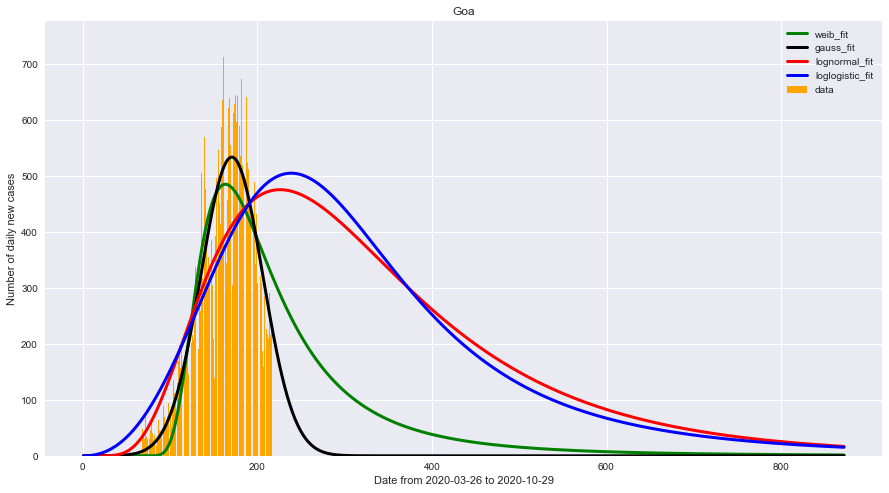

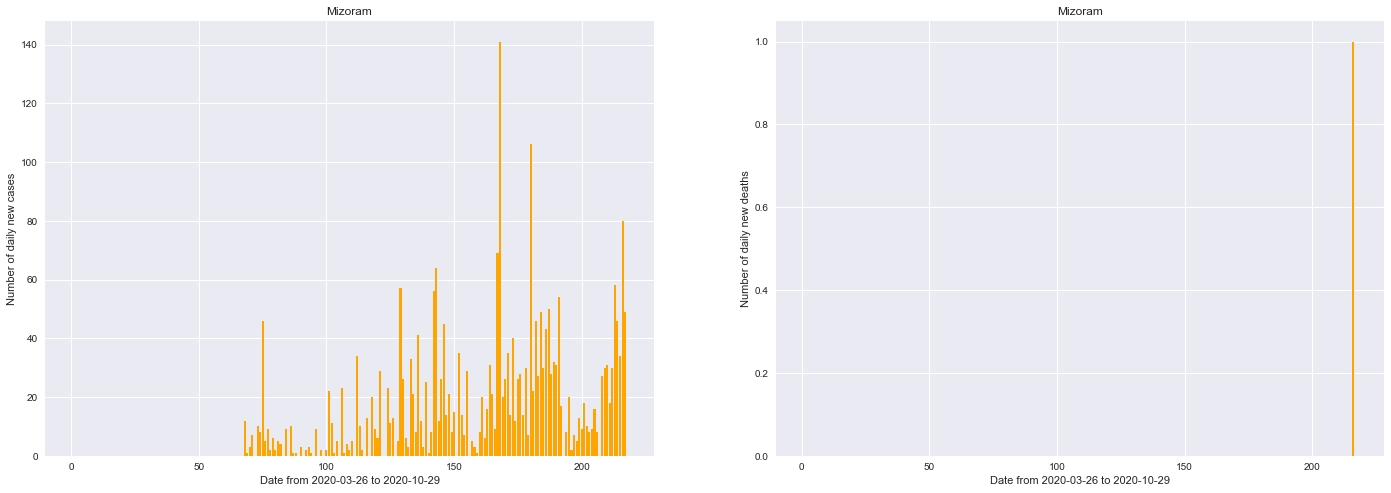

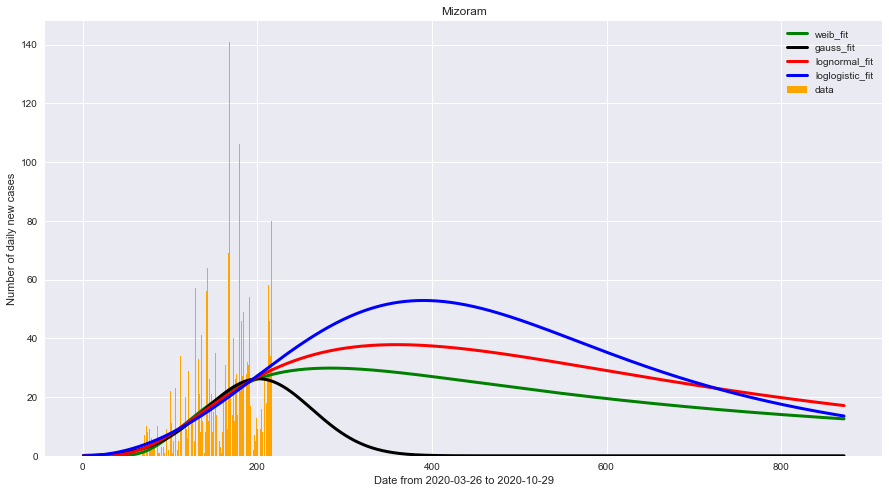

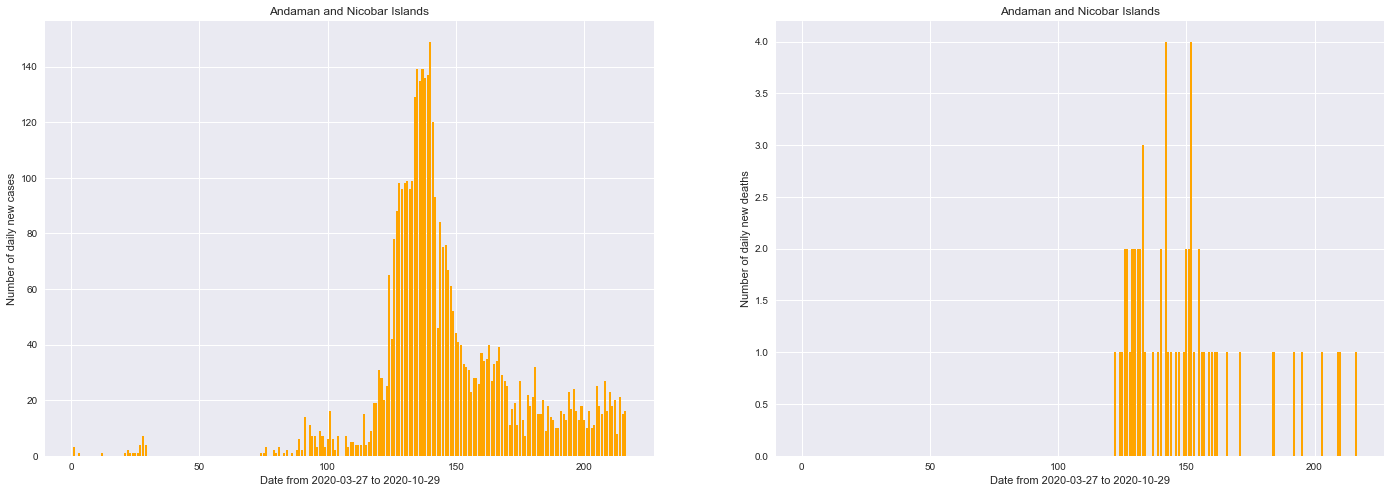

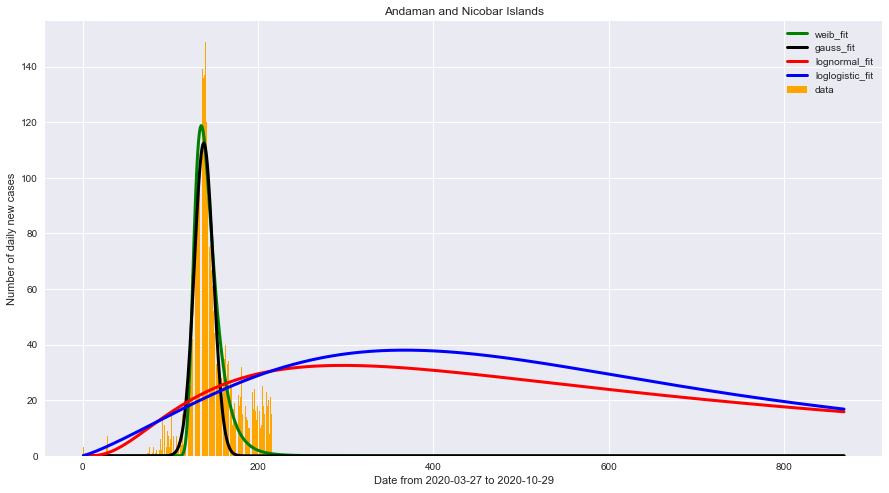

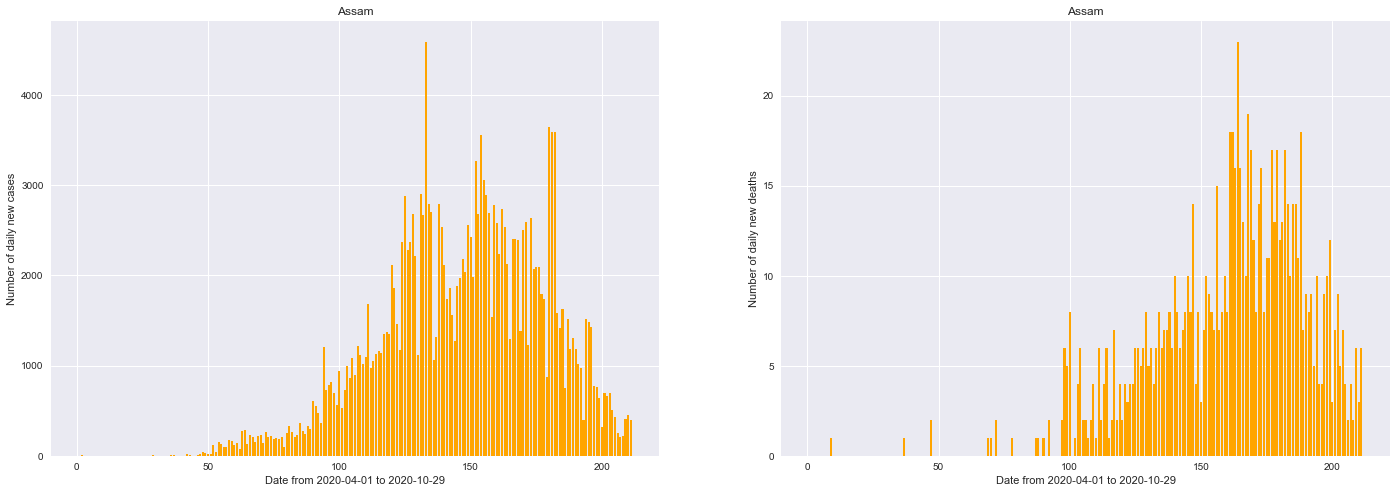

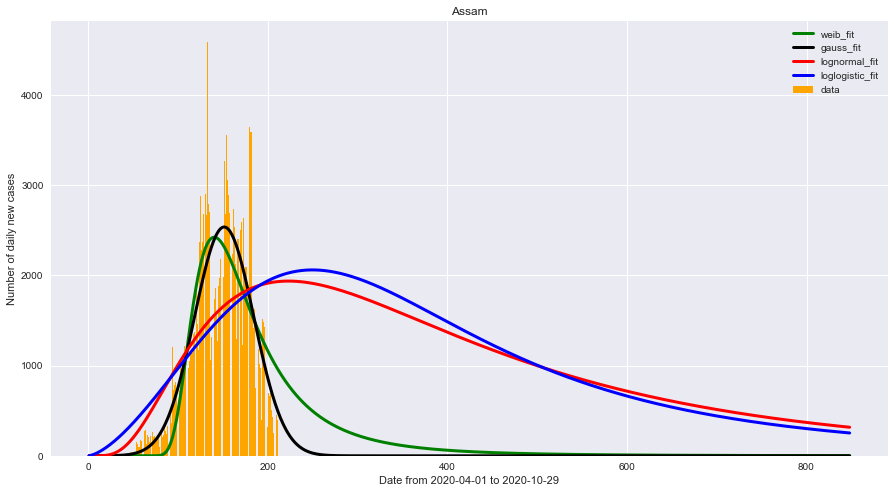

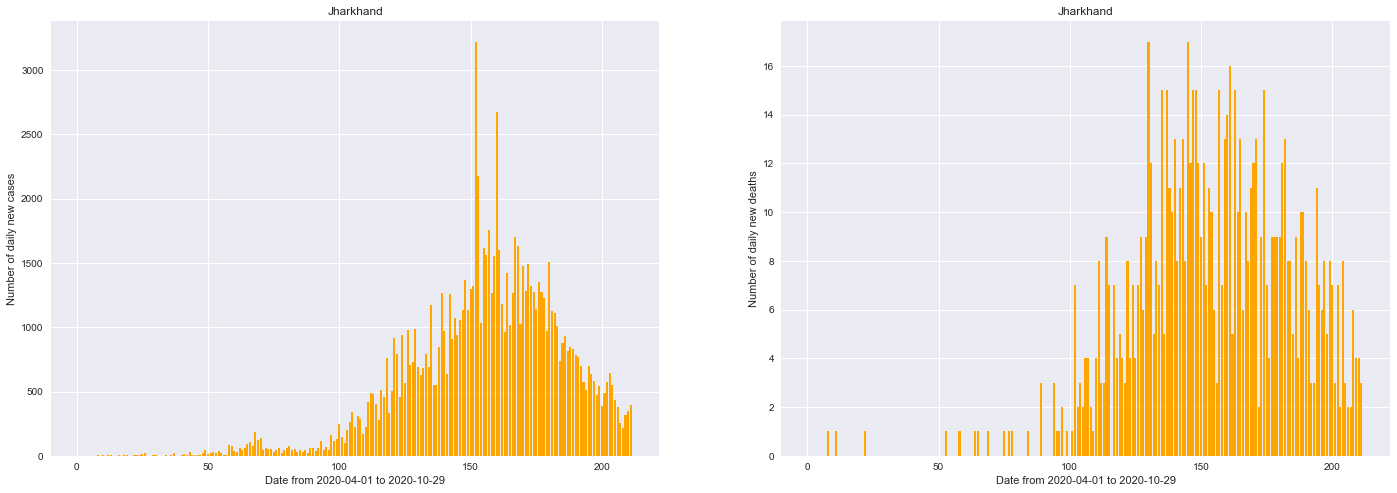

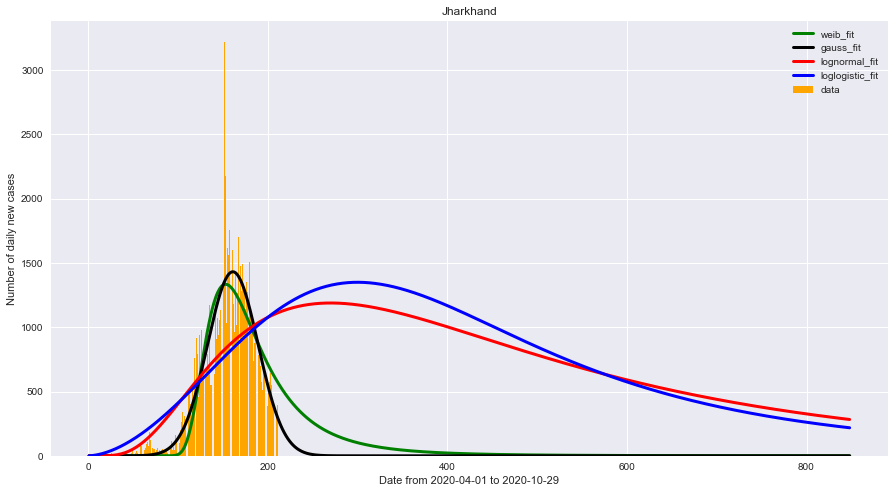

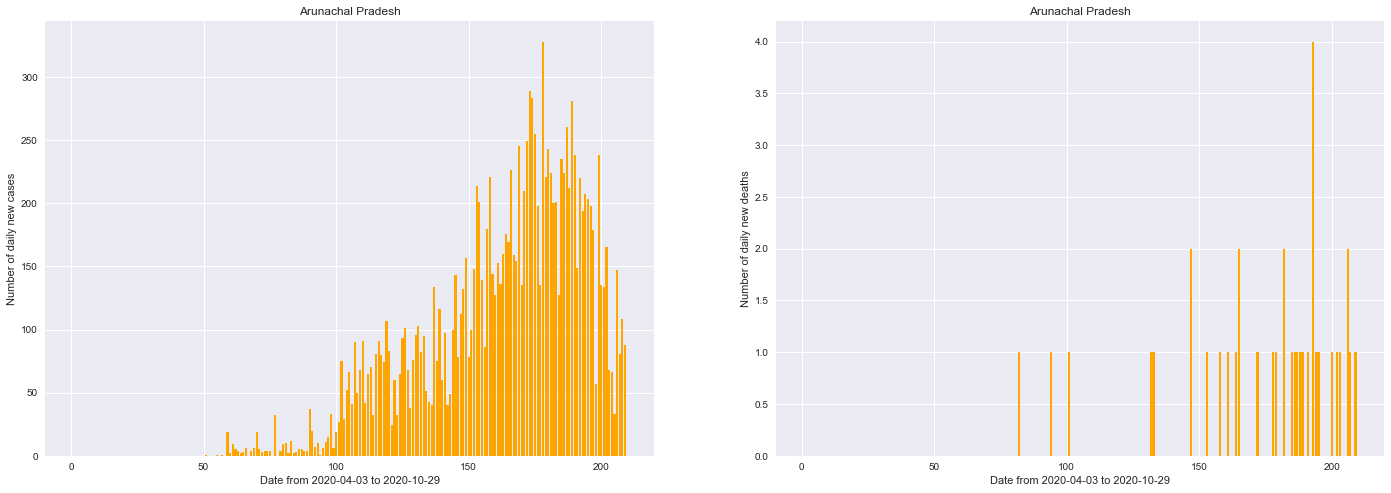

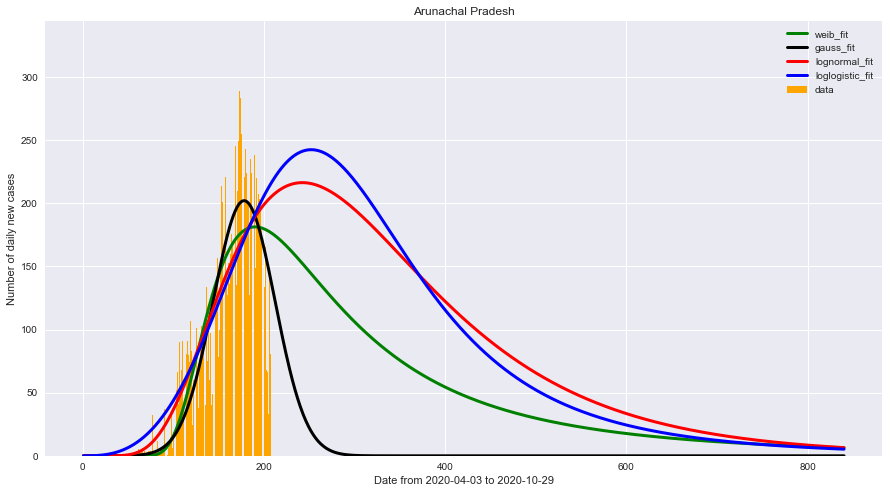

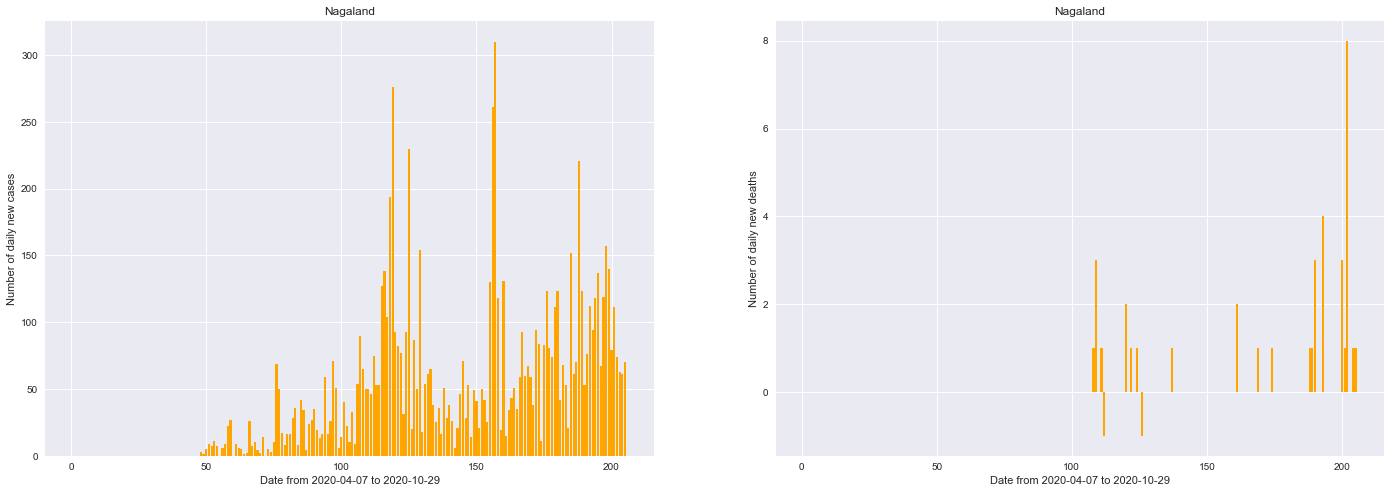

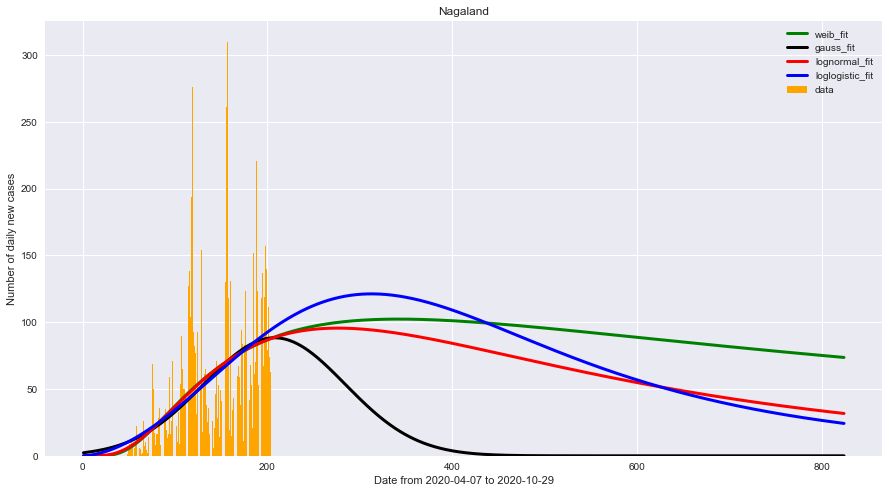

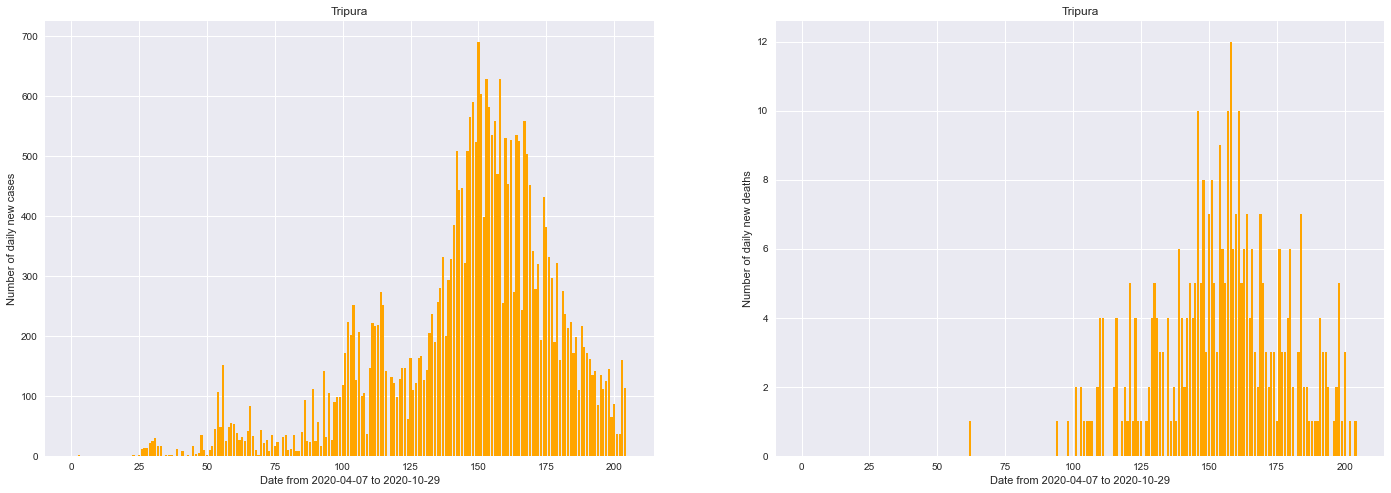

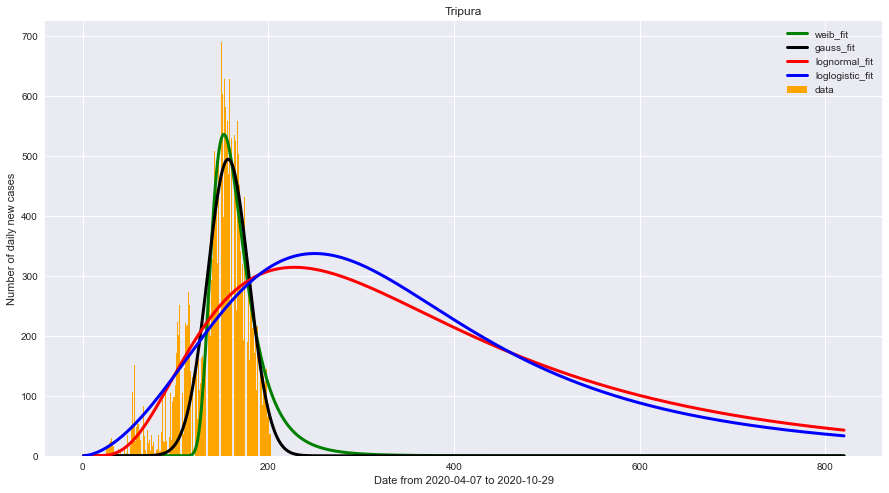

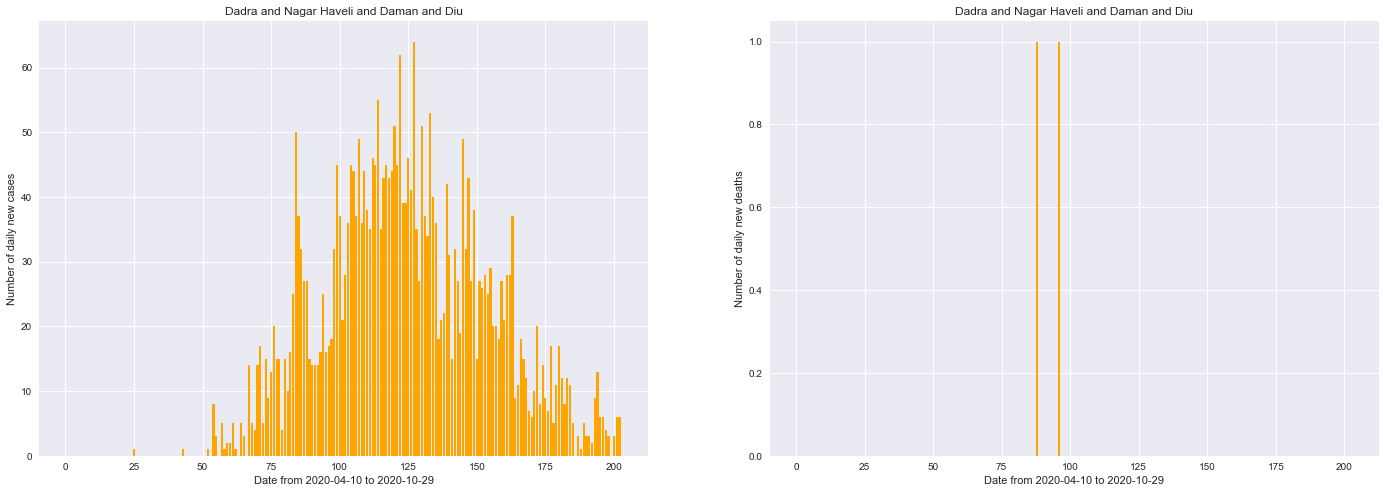

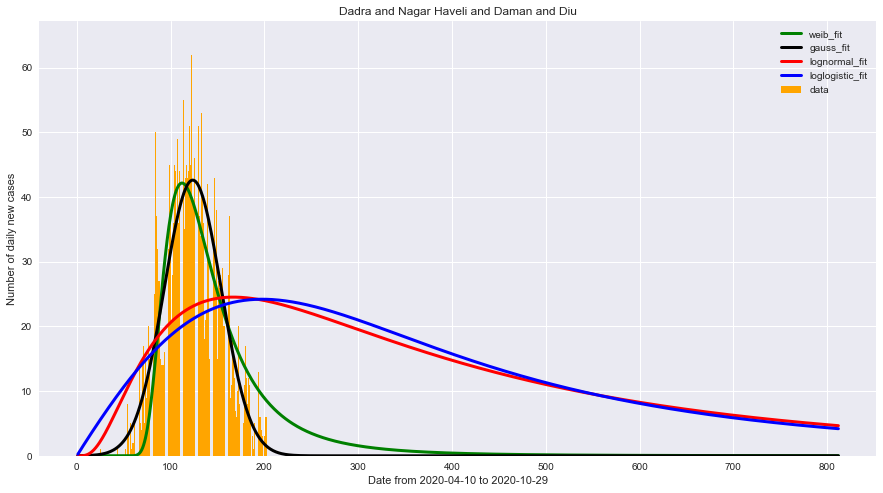

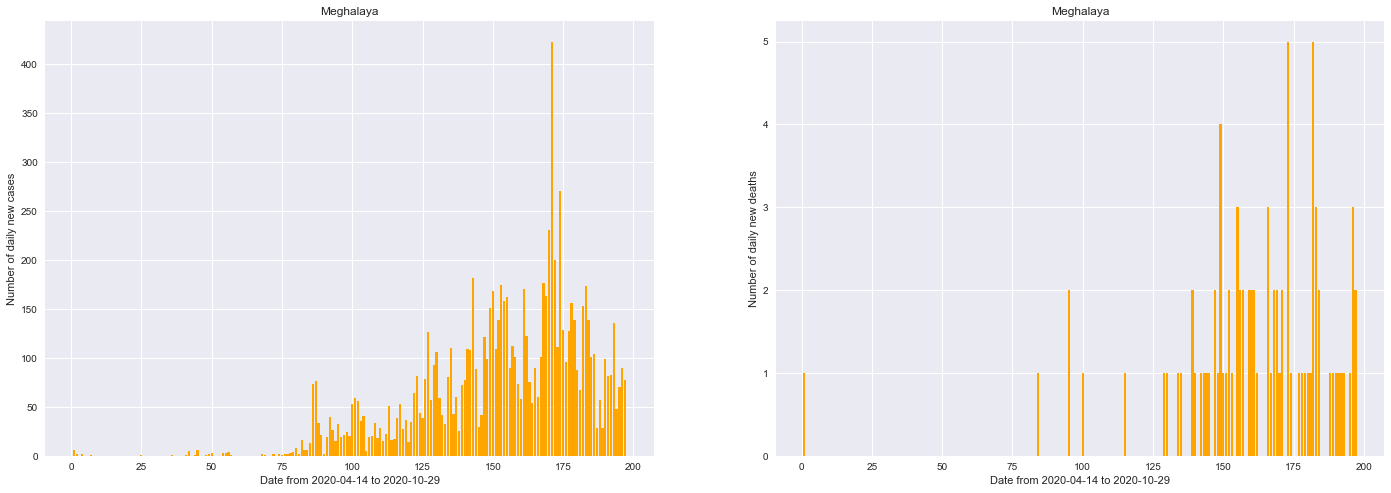

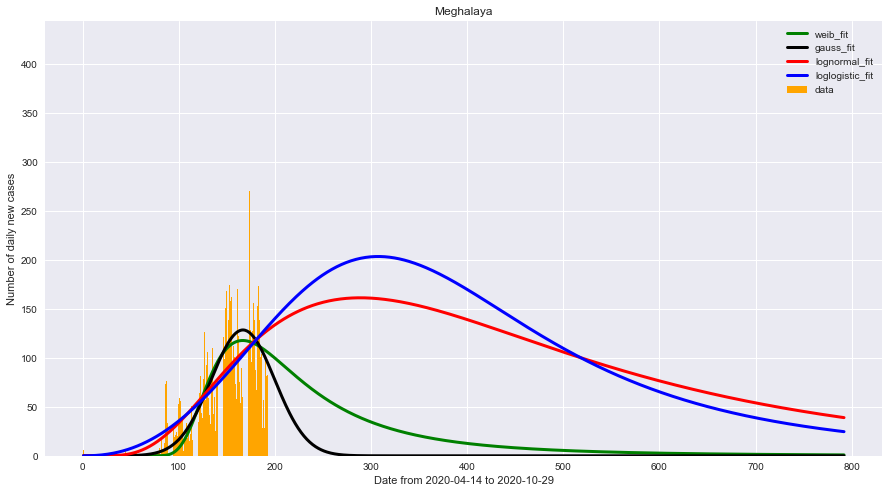

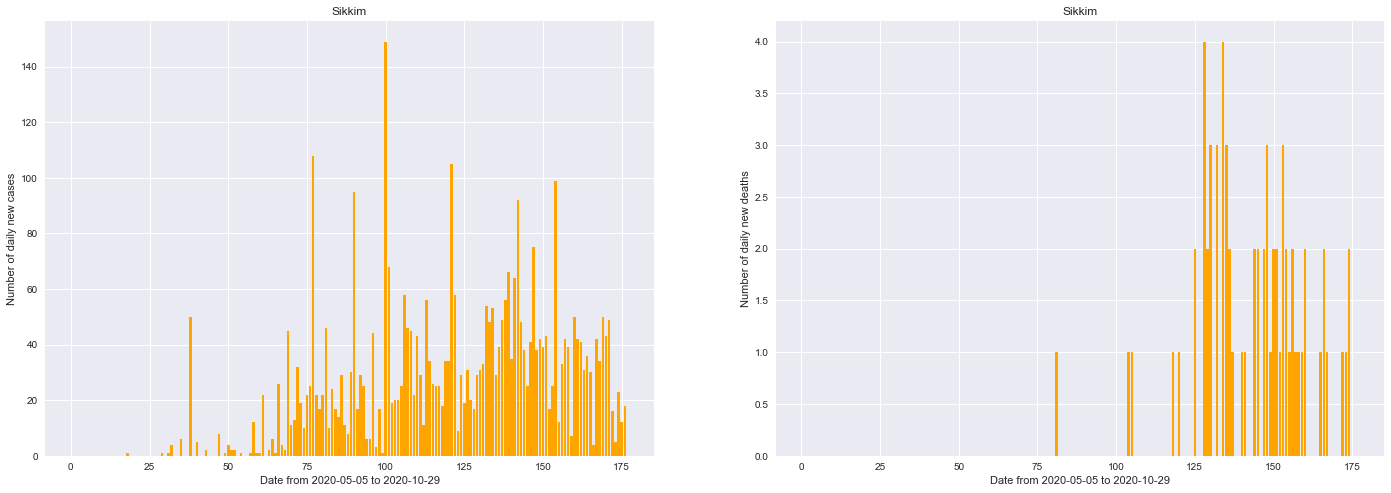

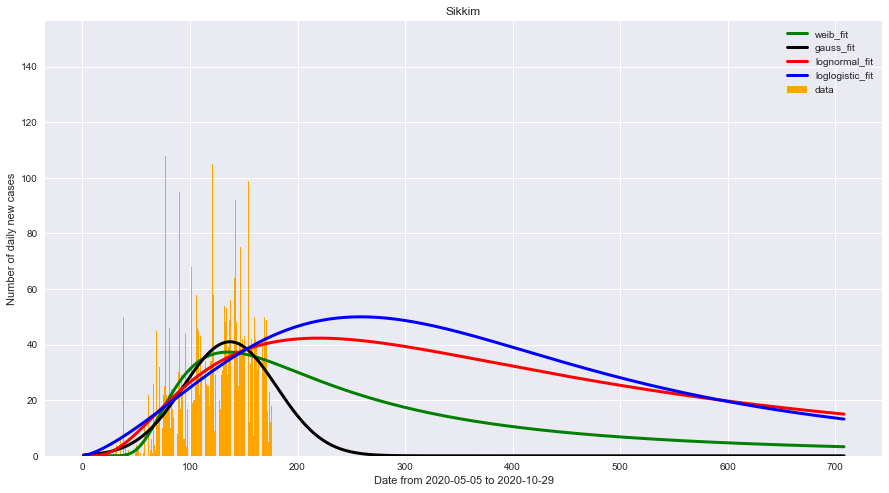

In [6]:
data =  pd.read_csv('states.csv')
states = list(pd.unique(data['State']))
states.remove('State Unassigned')
states.remove('India')
states.remove('Lakshadweep')


Final_matrics = []
models = ['Weibull', 'Gauss', 'LogNormal', ' LogLogistic']
names = ['y', 'z', 't', 'l']

for state in states:
    df_1 = data[data['State'] == state]
    df_1['new_cases'] = df_1.loc[:, 'Confirmed'] - df_1.loc[:, 'Confirmed'].shift(1)
    df_1['new_deaths'] = df_1.loc[:, 'Deceased'] - df_1.loc[:, 'Deceased'].shift(1)
    df_1 = df_1[df_1.new_cases >= 0]
    df_1 = df_1.reset_index()
    df_1 = df_1.drop('index', axis = 1)
   
    
    index = max(df_1[df_1.Date <= '2020-10-30'].index)
    startdate = min(df_1.Date)
    enddate = max(df_1.Date[1:index])
    
    
    x_data, y_data_cases, y_data_deaths = (df_1.index.values[1:index], df_1.new_cases.values[1:index], df_1.new_deaths.values[1:index])
    x_data_max, y_data_cases_max, y_data_deaths_max = (max(x_data), max(y_data_cases), max(y_data_deaths))
    
    
    fig, axes = plt.subplots(1, 2, figsize=(24,8))
    axes[0].bar(x_data, y_data_cases,color = 'orange')
    axes[0].set_title(state)
    axes[0].set_xlabel('Date from {} to {}'.format(startdate, enddate))
    axes[0].set_ylabel("Number of daily new cases")

    axes[1].bar(x_data, y_data_deaths,color = 'orange')
    axes[1].set_title(state)
    axes[1].set_xlabel('Date from {} to {}'.format(startdate, enddate))
    axes[1].set_ylabel("Number of daily new deaths");
    plt.savefig(state + '_data.png')
    
    xdata = x_data/x_data_max
    ydata_cases = y_data_cases/y_data_cases_max
    ydata_deaths = y_data_deaths/y_data_deaths_max
    
    popt_ind_weib, pcov_ind_weib = iterativeCurveFit(weib, xdata, ydata_cases)
    popt_ind_gauss, pcov_ind_gauss = iterativeCurveFit(gauss, xdata, ydata_cases)
    popt_ind_lognormal, pcov_ind_lognormal = iterativeCurveFit(lognormal, xdata, ydata_cases)
    popt_ind_loglogistic, pcov_ind_loglogistic = iterativeCurveFit(loglogistic, xdata, ydata_cases)
    
    # split data into train/test
    msk = np.random.rand(index-1) < 0.8
    train_x = xdata[msk]
    test_x = xdata[~msk]
    train_y = ydata_cases[msk]
    test_y = ydata_cases[~msk]

    y_hat = weib(test_x, *popt_ind_weib)
    z_hat = gauss(test_x, *popt_ind_gauss)
    t_hat = lognormal(test_x, *popt_ind_lognormal)
    l_hat = loglogistic(test_x, *popt_ind_loglogistic)

    hats = [y_hat, z_hat, t_hat, l_hat]

    xt = np.arange(1, 4*index)
    xt = 4*xt/max(xt)

    y = weib(xt, *popt_ind_weib)
    z = gauss(xt, *popt_ind_gauss)
    t = lognormal(xt, *popt_ind_lognormal)
    l = loglogistic(xt, *popt_ind_loglogistic)
    
    curves = [y, z, t, l]
    
    for i in range(4):
        Final_matrics.append({
            'State': state,
            'Function' : models[i],
            'Mean Absolute Error' : np.mean(np.absolute(hats[i] - test_y)),
            'Mean Squared Error' : np.mean((hats[i] - test_y) ** 2),
            'R2-Score' : r2_score(hats[i] , test_y),
            'Expected_Last_date': expectedEnd(names[i], curves[i], index, startdate)[0],
            'Expected_cases': expectedEnd(names[i], curves[i], index, startdate)[1]
        })
        

    plt.figure(figsize = (15,8))
    plt.bar(xdata*x_data_max, ydata_cases*y_data_cases_max, color = 'orange', label = 'data')
    plt.plot(xt*index, y*y_data_cases_max, 'green', linewidth = 3.0, label = 'weib_fit')
    plt.plot(xt*index, z*y_data_cases_max, 'black', linewidth = 3.0, label = 'gauss_fit')
    plt.plot(xt*index, t*y_data_cases_max, 'red', linewidth = 3.0, label = 'lognormal_fit')
    plt.plot(xt*index, l*y_data_cases_max, 'blue', linewidth = 3.0, label = 'loglogistic_fit')
    plt.title(state)
    plt.legend(loc = 'best')
    plt.ylabel("Number of daily new cases")
    plt.xlabel('Date from {} to {}'.format(startdate, enddate))
    plt.savefig(state + '.png')
    plt.show()

In [7]:
df = pd.DataFrame(Final_matrics, columns = ['State','Function', 'Mean Absolute Error', 'Mean Squared Error', 'R2-Score', 'Expected_Last_date','Expected_cases'])
df.to_csv('FinalMatrics_states.csv')